In [106]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)


n_mixtures = 20
hidden_size = 400
input_size = 3
batch_size = 128
n_epochs = 1000
max_length = 1200
lr = 1e-3
eps = 1e-6
model_name = "20210811_Synthesis"


cuda:2


In [107]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [108]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [109]:
from collections import defaultdict

alphabet = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
vocab_size = len(alphabet)
eos_char = '\x00'
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(alphabet))))
num_to_alpha = defaultdict(int, list(enumerate(alphabet)))

In [110]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    texts = [drawing.decode_ascii(s) + eos_char for s in strings]
    text_lengths = [len(t) for t in texts]
    
    max_text_length = max(text_lengths)
    num_texts = len(texts)
    one_hots = torch.zeros(num_texts, max_text_length, vocab_size, device=device)
    for i, text in enumerate(texts):
        for j, c in enumerate(text):
            one_hots[i, j, alpha_to_num[c]] = 1
    
    return standarized_strokes, means, std, stroke_lens, texts, text_lengths, one_hots, vocab_size

def string_to_one_hot(string):
    if (string[-1] != eos_char):
        string += eos_char
    one_hot = torch.zeros(len(string), vocab_size)
    for i, c in enumerate(string):
        one_hot[i, alpha_to_num[c]] = 1
    return one_hot

def one_hot_to_string(one_hot):
    # assuming that one_hot is numpy
    def get_char(arr):
        arr = list(arr)
        if 1 not in arr:
            return ''
        return num_to_alpha[list(arr).index(1)]
    return ''.join([get_char(a) for a in one_hot])

In [111]:
one_hot_to_string(string_to_one_hot("sample").numpy())

'sample\x00'

In [112]:
strokes, means, std, stroke_lengths, texts, text_lengths, one_hots, embedding_size  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
#print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, texts.shape, text_lengths.shape, one_hots.shape)


In [113]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [114]:
idx = torch.randint(low=0, high=len(texts), size=(1,)).item()
print(idx)
texts[idx]
text_lengths[idx]
one_hot_to_string(one_hots[idx])

181


'ghosts of dead monarchs and\x00'

28

'ghosts of dead monarchs and\x00'

In [115]:
embedding_size

73

In [12]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

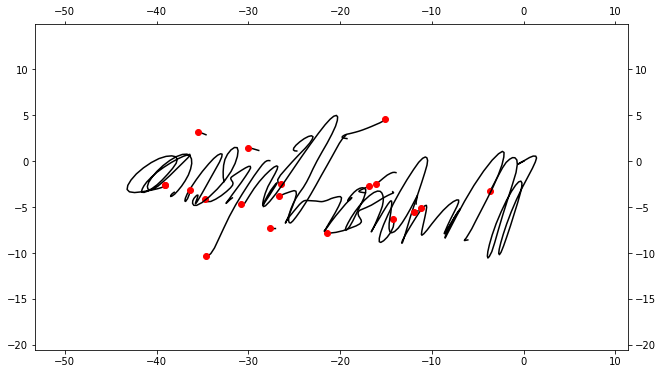

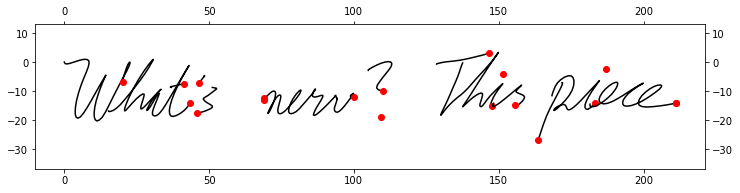

What 's new? This piece


In [15]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [16]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths, one_hots, text_lengths):
        assert len(strokes) == len(one_hots)
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.one_hots = one_hots
        self.one_hot_lengths = text_lengths
        self.stroke_mask = self.getStrokeMask()
        self.one_hot_mask = self.getOneHotMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.stroke_mask[idx], self.one_hots[idx], self.one_hot_lengths[idx], self.one_hot_mask[idx]
    
    def getStrokeMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            # The mask is true to the string lengths.
            # Any offsets for Special training of RNN needs to be handled separately
            mask[i][self.stroke_lengths[i]:] = 0
        return mask
    
    def getOneHotMask(self):
        mask = np.ones((self.one_hots.shape[0], self.one_hots.shape[1]))
        for i in range(self.one_hots.shape[0]):
            # The mask is true to the string lengths.
            # Any offsets for Special training of RNN needs to be handled separately
            mask[i][self.one_hot_lengths[i]:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:-150], stroke_lengths[:-150], one_hots[:-150], text_lengths[:-150])
test_dataset = HandwritingDataset(strokes[-150:], stroke_lengths[-150:], one_hots[-150:], text_lengths[-150:])


In [17]:
dl = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=2,
    drop_last=True)

k = iter(dl)
for j in range(1):
    print("JJJJJJJJJJJJJJJJJ:", j)
    s, l, m, oh, ohl, ohm = next(k)
    l0 = l[0]
    l1 = l[1]
    l
    s.shape
    m.shape

    print("Testing the 0th position of every stroke")
    s[:,0,:]

    print("testing the length location of stroke")
    s[0,l0-2:l0+2, :]
    s[1,l1-2:l1+2, :]

    print("testing the length location of mask")
    m[0,l0-2:l0+2]
    m[1,l1-2:l1+2]
    
    
    l0 = ohl[0]
    l1 = ohl[1]
    ohl
    oh.shape
    ohm.shape

    print("Testing the 0th position of every one hot")
    oh[:,0,:]

    print("testing the length location of one hot")
    oh[0,l0-2:l0+2, :]
    oh[1,l1-2:l1+2, :]

    print("testing the length location of mask")
    ohm[0,l0-2:l0+2]
    ohm[1,l1-2:l1+2]
    
    
    

JJJJJJJJJJJJJJJJJ: 0


tensor([535, 401], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1200])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.4407, -0.4250,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.2238,  0.0789,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 1., 0., 0.], dtype=torch.float64)

tensor([1., 1., 0., 0.], dtype=torch.float64)

tensor([34, 20])

torch.Size([2, 65, 73])

torch.Size([2, 65])

Testing the 0th position of every one hot


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]], device='cuda:2')

testing the length location of one hot


tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


testing the length location of mask


tensor([1., 1., 0., 0.], dtype=torch.float64)

tensor([1., 1., 0., 0.], dtype=torch.float64)

In [44]:
bs = 2
u = torch.arange(1, 11, device=device)[None, :, None].repeat(bs, 1, 1)
alpha = torch.rand(bs, 5)[:, None]
beta = torch.rand(bs, 5)[:, None]
kappa = torch.randn(bs, 5)[:, None]
u, u.shape
alpha, alpha.shape
beta, beta.shape
kappa, kappa.shape
res = alpha * torch.exp(-beta * (kappa - u)**2)
res.shape
res.sum(dim=-1).shape

(tensor([[[ 1],
          [ 2],
          [ 3],
          [ 4],
          [ 5],
          [ 6],
          [ 7],
          [ 8],
          [ 9],
          [10]],
 
         [[ 1],
          [ 2],
          [ 3],
          [ 4],
          [ 5],
          [ 6],
          [ 7],
          [ 8],
          [ 9],
          [10]]], device='cuda:2'),
 torch.Size([2, 10, 1]))

(tensor([[[0.8396, 0.6015, 0.5620, 0.0551, 0.6033]],
 
         [[0.9493, 0.7880, 0.1941, 0.0802, 0.6681]]]),
 torch.Size([2, 1, 5]))

(tensor([[[0.4832, 0.2251, 0.5815, 0.9507, 0.9056]],
 
         [[0.2027, 0.4312, 0.8921, 0.9371, 0.9627]]]),
 torch.Size([2, 1, 5]))

(tensor([[[ 0.6577, -0.9206,  0.2249, -0.4471,  1.2884]],
 
         [[ 0.5968,  1.3704, -0.7678,  0.8303, -0.4154]]]),
 torch.Size([2, 1, 5]))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu!

In [48]:
b = torch.rand(2, 9)
b[None].shape
b[:, None].shape
b[:, :, None].shape
b.chunk(5, -1)

a = torch.rand(2, 3, 4)
wt = torch.randn(2, 3)[:, :, None]
a 
wt
(a * wt).sum(1)

torch.Size([1, 2, 9])

torch.Size([2, 1, 9])

torch.Size([2, 9, 1])

(tensor([[0.2972, 0.5181],
         [0.1118, 0.5267]]),
 tensor([[0.1066, 0.2280],
         [0.9845, 0.1480]]),
 tensor([[0.8972, 0.8981],
         [0.8433, 0.0047]]),
 tensor([[0.6402, 0.3537],
         [0.7986, 0.5129]]),
 tensor([[0.5252],
         [0.1122]]))

tensor([[[4.1425e-04, 7.2843e-01, 1.3126e-01, 1.3980e-01],
         [1.7582e-01, 5.6026e-01, 9.5616e-01, 1.2855e-02],
         [4.9045e-01, 6.5498e-01, 5.9449e-01, 5.6505e-01]],

        [[2.6322e-01, 1.0883e-01, 1.3641e-01, 9.7324e-01],
         [4.6293e-01, 7.9019e-02, 8.7878e-01, 5.4635e-01],
         [5.7785e-01, 4.1154e-01, 5.0455e-01, 9.4366e-01]]])

tensor([[[-1.5799],
         [-0.9028],
         [-0.2521]],

        [[-0.9580],
         [ 0.8424],
         [ 0.3103]]])

tensor([[-0.2830, -1.8218, -1.2205, -0.3749],
        [ 0.3171,  0.0900,  0.7661, -0.1793]])

In [97]:
class GaussianAttention(nn.Module):
    def __init__(self, lstm_hidden_size, n_mixtures):
        super(GaussianAttention, self).__init__()
        self.n_mixtures = n_mixtures
        self.linear_layer = nn.Linear(lstm_hidden_size, 3*n_mixtures)
        
    def forward(self, h, kappa_prev, one_hot_batch, one_hot_mask, eps=1e-6):
        B, T = one_hot_mask.shape
        
        out_1 = self.linear_layer(h) # (B, 3*K)
        alpha, beta, kappa = torch.exp(out_1)[:, None].chunk(3, dim=-1) # (B, 1, K) each
        kappa = kappa + kappa_prev
        
        u = torch.arange(1, T+1, device="cpu")[None, :, None].repeat(B, 1, 1) # (B, T, 1)
        
        phi = alpha * torch.exp(-beta * torch.pow(kappa - u, 2)) # (B, T, K)
        phi = phi.sum(dim=-1) # (B, T)
        print("Before masmking", phi)

        phi = (phi * one_hot_mask)[:, :, None] # (B, T, 1)
        print("After masmking", phi)
        
        w = (phi * one_hot_batch).sum(1) # (B, V) V = vocab_size
        print(w.shape)
        
        attn_params = {
            "w": w,
            "phi": phi,
            "alpha": alpha,
            "beta": beta,
            "kappa": kappa
        }

        return attn_params
        

In [98]:
# batch_size = 2
# hidden_size = 4
# input_size = 3
# n_mixtures = 5
# vocab_size = 6
# timesteps = 7

# h = torch.randn(batch_size, hidden_size)
# kappa_prev = torch.randn(batch_size, n_mixtures)[:,None,:]
# ohb = torch.randn(batch_size, timesteps, vocab_size)
# ohm = torch.ones(batch_size, timesteps)
# ohm[0, 5:] = 0
# ohm[1, 3:] = 0
# ohm
# gl = GaussianAttention(hidden_size, n_mixtures)
# gl(h, kappa_prev, ohb, ohm)

In [99]:
from einops import rearrange 

class HandwritingSynthesis(nn.Module):
    def __init__(self, input_size, hidden_size, n_output_mixtures, n_attn_mixtures, embedding_size):
        super(HandwritingSynthesis, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output_mixtures = n_output_mixtures
        self.n_attn_mixtures = n_attn_mixtures
        self.embedding_size = embedding_size
        self.output_size = 6*n_output_mixtures + 1
        
        self.lstm1 = nn.LSTMCell(input_size + embedding_size, hidden_size)
        self.gaussian_attn = GaussianAttention(hidden_size, n_attn_mixtures)
        self.lstm2 = nn.LSTMCell(embedding_size + input_size + hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, self.output_size)
        
    def forward(self, stroke_t, one_hots, one_hot_mask, prev_state):
        bs = stroke_t.shape[0]
        # K: n_attn_mixtures, E: embedding_size, H: hidden_size, T: Total timesteps
        # stroke_t: (B,3), kappa: (B,1,K), attn: (B,E), hidden h and c : (B, H)
        # one_hots : (B, T, E), one_hot_mask = (B, T)
        attn_params_prev, hid_1, hid_2 = prev_state
        attn_prev = attn_params_prev["w"]
        kappa_prev = attn_params_prev["kappa"]
        
        hid_1 = self.lstm1(
            torch.cat([stroke_t, attn_prev], dim=-1),
            hid_1)
        
        attn_params_new = self.gaussian_attn(
            hid_1[0],
            kappa_prev,
            one_hots,
            one_hot_mask)
        
        attn_new = attn_params_new["w"]
        
        hid_2 = self.lstm2(
            torch.cat([stroke_t, attn_new, hid_1[0]], dim=-1),
            hid_2)
        
        out = self.linear(hid_2[0])
        
        return out, (attn_params_new, hid_1, hid_2)

In [102]:
batch_size = 2
input_size = 3
hidden_size = 4
n_output_mixtures = 8
n_attn_mixtures = 5
embedding_size = 6
timestamps = 7

h = HandwritingSynthesis(input_size, hidden_size, n_output_mixtures, n_attn_mixtures, embedding_size)

stroke = torch.randn(batch_size, 3)
stroke[:, 2] = 0
stroke

one_hots = torch.zeros(batch_size, timestamps, embedding_size)
one_hots[0,:5, 0]= 1
one_hots[1, :3, 3] =1
print("one_hots", one_hots)

one_hot_mask = torch.ones(batch_size, timestamps)
one_hot_mask[0,5:] = 0
one_hot_mask[1,3:] = 0
print("one_hot_mask", one_hot_mask)

attn = {
    "w": torch.randn(batch_size, embedding_size),
    "phi": torch.randn(batch_size, timestamps, 1),
    "alpha": torch.randn(batch_size, 1, n_attn_mixtures),
    "beta": torch.randn(batch_size, 1, n_attn_mixtures),
    "kappa": torch.randn(batch_size, 1, n_attn_mixtures)
}
prev_state = (attn,
              (torch.zeros(batch_size, hidden_size), torch.zeros(batch_size, hidden_size)),
              (torch.zeros(batch_size, hidden_size), torch.zeros(batch_size, hidden_size)))
print("prev_state", prev_state)


h(stroke, one_hots, one_hot_mask, prev_state)

tensor([[-0.1097,  1.0831,  0.0000],
        [-1.6670,  0.0216,  0.0000]])

one_hots tensor([[[1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]])
one_hot_mask tensor([[1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.]])
prev_state ({'w': tensor([[-0.0973,  0.9561, -0.1729,  0.3253, -0.3390,  0.3409],
        [-0.0329, -0.0867,  1.2252,  2.8282, -0.3329,  0.5210]]), 'phi': tensor([[[-1.3368],
         [-0.7225],
         [ 1.1002],
         [ 1.3285],
         [-1.3705],
         [-1.5598],
         [-0.8208]],

        [[ 0.2176],
         [ 0.6819],
         [-0.2586],
         [-0.0097],
         [-0.6755],
         [

(tensor([[ 0.4153,  0.3367, -0.0838,  0.3122, -0.2586, -0.3681, -0.0563, -0.0564,
          -0.0035,  0.3048,  0.1454,  0.0052, -0.4313, -0.0331,  0.0609,  0.2889,
           0.4166, -0.0474,  0.3677,  0.2962,  0.3074, -0.2258, -0.2963, -0.1140,
           0.0513,  0.5224,  0.1514,  0.3507, -0.2342, -0.0488, -0.1110, -0.4428,
          -0.2816,  0.1407, -0.0923,  0.0062, -0.5142, -0.3305, -0.2231, -0.2355,
          -0.5562, -0.4724, -0.2708, -0.0226,  0.1956, -0.3451, -0.4567, -0.2702,
           0.0205],
         [ 0.3791,  0.2152,  0.1088,  0.1815, -0.3591, -0.5836, -0.1305,  0.0485,
           0.0889,  0.4441,  0.0621, -0.0457, -0.5022,  0.0241,  0.0070,  0.4834,
           0.3400,  0.1009,  0.2884,  0.3031,  0.2351, -0.2509, -0.4656, -0.0248,
           0.2313,  0.5547,  0.1749,  0.6159, -0.2262,  0.0085, -0.1334, -0.0975,
          -0.4206, -0.0928,  0.0502,  0.2032, -0.6468, -0.7345, -0.3308, -0.3683,
          -0.6914, -0.7121, -0.4894,  0.0149,  0.1499, -0.2479, -0.3087, -0.23

In [13]:
def get_mixture_params_from_output(outputs):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    pis = nn.Softmax(2)(outputs[:,:,:n_mixtures])
    mus = rearrange(outputs[:,:,n_mixtures:3*n_mixtures], 'b l (n d) -> b l n d', d=2)
    
    sigmas = rearrange(torch.exp(outputs[:,:,3*n_mixtures:5*n_mixtures]), 'b l (n d) -> b l n d', d=2) + eps
    phos = rearrange((1-eps) * torch.tanh(outputs[:,:,5*n_mixtures:6*n_mixtures]), 'b l (n d) -> b l n d', d=1)

    
    covs = torch.zeros(outputs.shape[0], outputs.shape[1], n_mixtures, 2, 2, device=device)
    covs[:,:,:,0,0] = sigmas[:,:,:,0]**2
    covs[:,:,:,1,1] = sigmas[:,:,:,1]**2
    covs[:,:,:,0,1] = phos[:,:,:,0] * sigmas[:,:,:,0] * sigmas[:,:,:,1]
    covs[:,:,:,1,0] = covs[:,:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,:,-1]))

def nll(outputs, targets, mask_batch):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    # targets: b, max_len-1, 3
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,:,0:2].unsqueeze(2).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=2)
    # target_coords: b, max_len-1, n_mixtures, 3
    stroke_lift = targets[:,:,-1] # b, max_len-1, 1
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords) + eps
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=2)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    loss_per_point *= mask_batch
    
    return loss_per_point.sum()/outputs.shape[0]

In [14]:
def get_initial_prev_states(mode='train'):
    dim = batch_size if mode == 'train' else 1
    h01 = torch.zeros(dim, hidden_size, device=device)
    c01 = torch.zeros(dim, hidden_size, device=device)
    h02 = torch.zeros(dim, hidden_size, device=device)
    c02 = torch.zeros(dim, hidden_size, device=device)
    
    attn_params = {
        "kappa": torch.zeros(dim, n_attn_mixtures, device=device),
        "w": torch.zeros(dim, embedding_size, device=device)
    }
    
    prev_states = (attn_params, (h01, c01), (h02, c02))
    return prev_states

def get_next_point(model, point_prev, prev_states):
    with torch.no_grad():
        outputs, prev_states = model(point_prev.unsqueeze(0).unsqueeze(0), prev_states)
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0).squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0).squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), prev_states
        
def sample(model, text):
    timestamps = 1200
    text_one_hot = string_to_one_hot(text)
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    prev_states = get_initial_prev_states("sample")
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, prev_states = get_next_point(model, prev_point, prev_states)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [117]:
dl = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=2,
    drop_last=True)
next(iter(dl))
l = tensor([89, 23])
l.max()

[tensor([[[ 0.0000,  0.0000,  0.0000],
          [-0.1971, -0.4458,  0.0000],
          [-0.1507, -0.7578,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000],
          [-0.2414,  0.0258,  0.0000],
          [-0.2561, -0.0721,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]),
 tensor([555, 503], dtype=torch.int16),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.

tensor(89)

In [103]:
from einops import rearrange

def get_inputs_targets_from_batch(strokes_batch, strokes_mask):
    inputs = strokes_batch[:, :-1, :]
    targets = strokes_batch[:, 1:, :]
    mask = strokes_mask[:, 1:]
    return inputs, targets, mask

def train_batch(model,
                optimizer,
                strokes,
                strokes_mask,
                one_hots,
                one_hots_mask,
                prev_states,
                output_holder):
    
    optimizer.zero_grad()
    
    inputs, targets, mask = get_inputs_targets_mask(strokes_batch, strokes_mask)
    
    T = inputs.shape[1] - 1
    
    for t in range(T): 
        output_holder[t], prev_state = model(
            inputs[:, t, :],
            one_hots,
            one_hot_mask,
            prev_state)
    loss = nll(output_holder, targets, mask)
    loss.backward()
    
    #### Do Gradient clipping here if need be
    torch.nn.utils.clip_grad_value_(model.parameters(), 10)
    torch.nn.utils.clip_grad_value_(loss, 100)
    
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    prev_states = get_initial_prev_states("train")
    output_holder = torch.zeros(batch_size, timestamps-1, 6*n_mixtures+1)
    for epoch in range(num_epochs):
        
        for strokes, _, strokes_mask, one_hots, _, one_hots_mask in train_dataloader:
            strokes = strokes.to(device)
            strokes_mask = strokes_mask.to(device)
            one_hots = one_hots.to(device)
            one_hots_mask = one_hots_mask.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes,
                strokes_mask,
                one_hots,
                one_hots_mask,
                prev_states,
                output_holder)
            prev_states = [
                (x[0].detach(), x[1].detach()) if type(x) is tuple else x.detach()
                for x in prev_states]
            output_holder = output_holder.detach()
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                for i in range(3):
                    sample_stroke = sample(model)
                    sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                    sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                    draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [16]:

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


/home/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:992: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627542741873/work/build/aten/src/ATen/core/TensorBody.h:802.)
  return self._grad


iteration: 0 of 78000, avg_loss: 42.94, timeSinceStart: 4.51, Epoch: 0


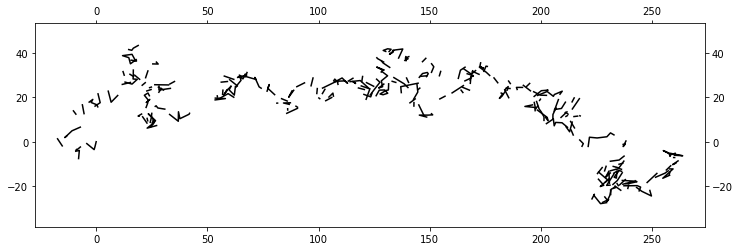

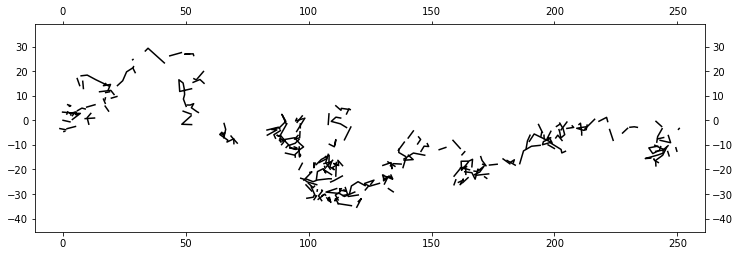

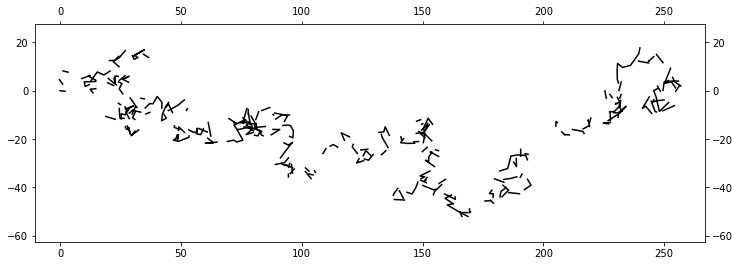

iteration: 50 of 78000, avg_loss: 736.55, timeSinceStart: 50.93, Epoch: 0
iteration: 100 of 78000, avg_loss: -590.23, timeSinceStart: 93.51, Epoch: 1
iteration: 150 of 78000, avg_loss: -1305.39, timeSinceStart: 136.19, Epoch: 1
iteration: 200 of 78000, avg_loss: -1460.04, timeSinceStart: 178.77, Epoch: 2
iteration: 250 of 78000, avg_loss: -1554.59, timeSinceStart: 221.47, Epoch: 3


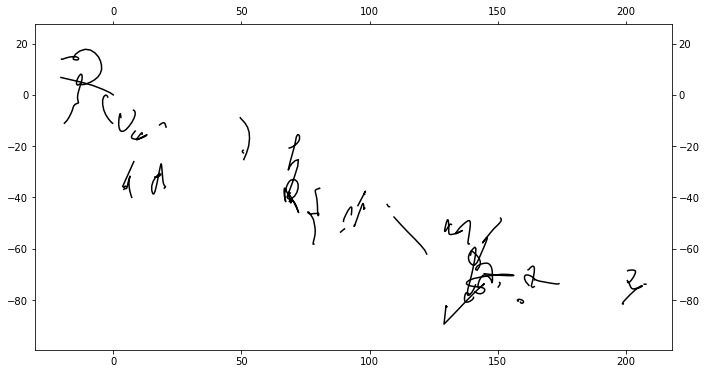

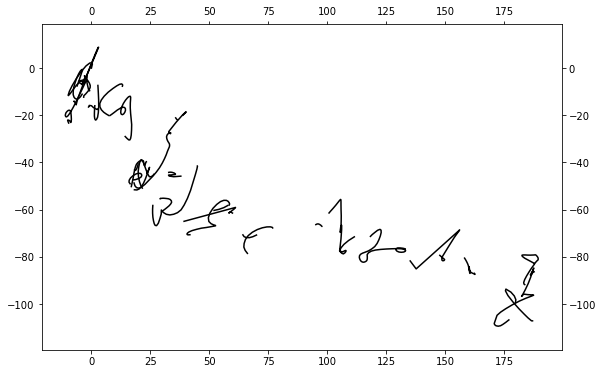

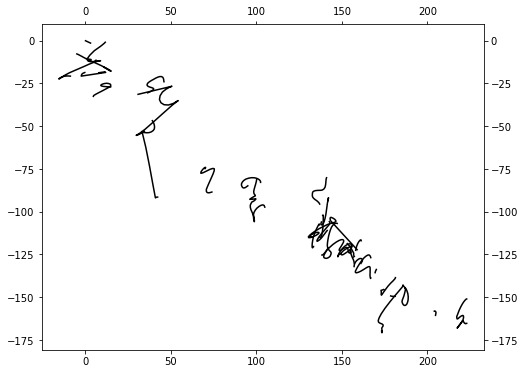

iteration: 300 of 78000, avg_loss: -1594.53, timeSinceStart: 267.30, Epoch: 3
iteration: 350 of 78000, avg_loss: -1613.16, timeSinceStart: 310.00, Epoch: 4
iteration: 400 of 78000, avg_loss: -1630.00, timeSinceStart: 352.95, Epoch: 5
iteration: 450 of 78000, avg_loss: -1642.90, timeSinceStart: 395.69, Epoch: 5
iteration: 500 of 78000, avg_loss: -1670.54, timeSinceStart: 438.42, Epoch: 6


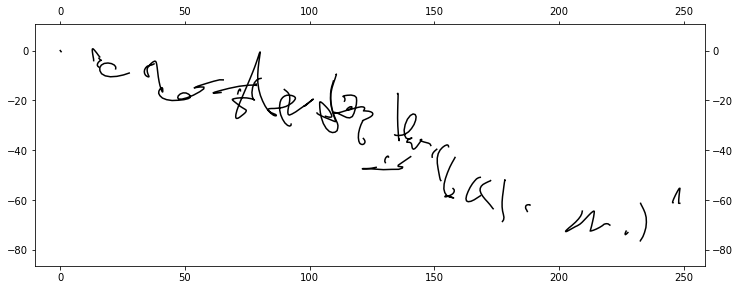

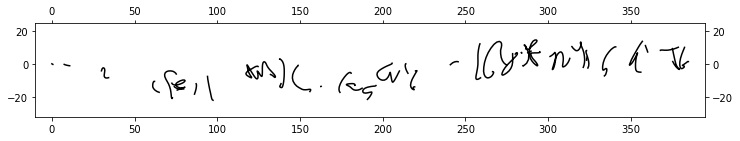

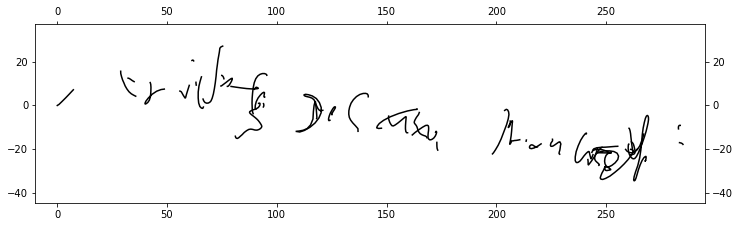

iteration: 550 of 78000, avg_loss: -1679.47, timeSinceStart: 484.29, Epoch: 7
iteration: 600 of 78000, avg_loss: -1712.12, timeSinceStart: 527.08, Epoch: 7
iteration: 650 of 78000, avg_loss: -1741.49, timeSinceStart: 569.71, Epoch: 8
iteration: 700 of 78000, avg_loss: -1750.35, timeSinceStart: 612.44, Epoch: 8
iteration: 750 of 78000, avg_loss: -1757.54, timeSinceStart: 655.21, Epoch: 9


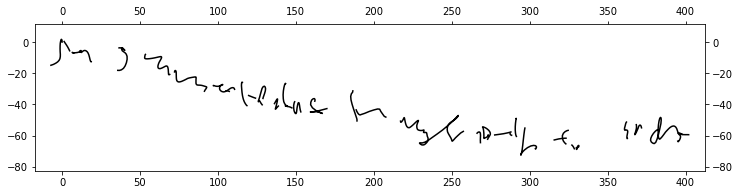

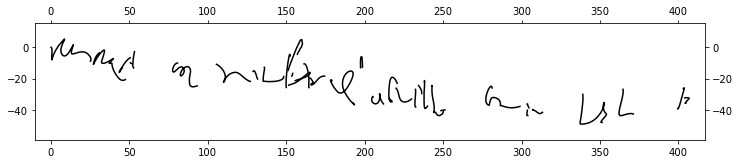

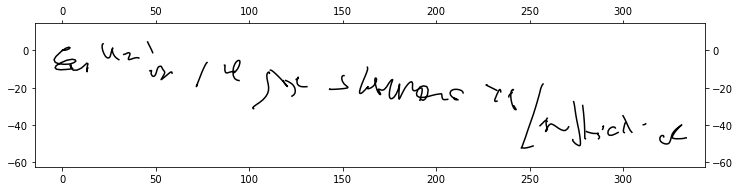

iteration: 800 of 78000, avg_loss: -1776.49, timeSinceStart: 701.05, Epoch: 10
iteration: 850 of 78000, avg_loss: -1746.71, timeSinceStart: 743.71, Epoch: 10
iteration: 900 of 78000, avg_loss: -1780.22, timeSinceStart: 786.54, Epoch: 11
iteration: 950 of 78000, avg_loss: -1819.80, timeSinceStart: 829.14, Epoch: 12
iteration: 1000 of 78000, avg_loss: -1839.56, timeSinceStart: 871.89, Epoch: 12


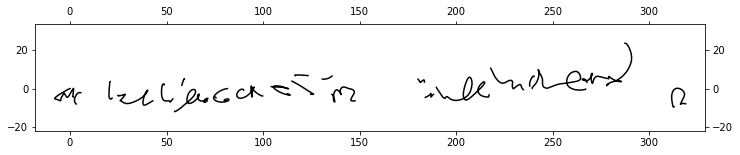

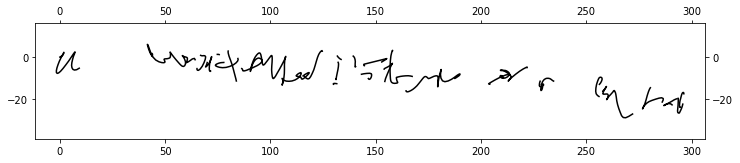

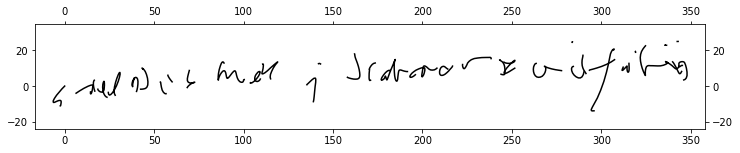

iteration: 1050 of 78000, avg_loss: -1874.31, timeSinceStart: 917.74, Epoch: 13
iteration: 1100 of 78000, avg_loss: -1882.92, timeSinceStart: 960.53, Epoch: 14
iteration: 1150 of 78000, avg_loss: -1874.40, timeSinceStart: 1003.27, Epoch: 14
iteration: 1200 of 78000, avg_loss: -1882.19, timeSinceStart: 1046.18, Epoch: 15
iteration: 1250 of 78000, avg_loss: -1924.68, timeSinceStart: 1088.90, Epoch: 16


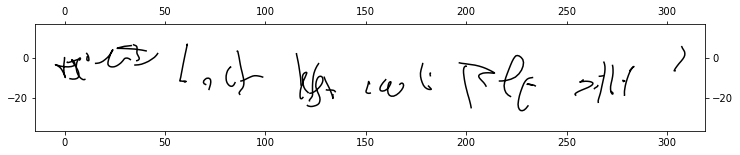

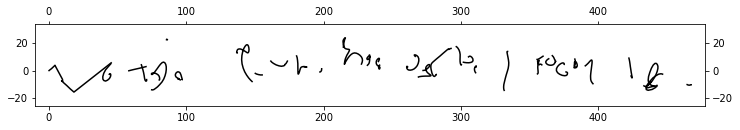

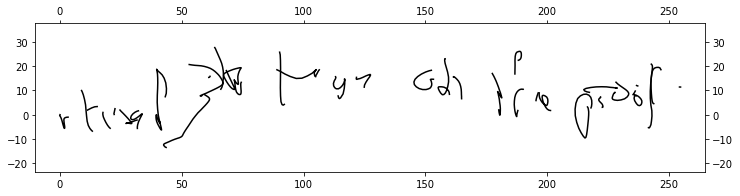

iteration: 1300 of 78000, avg_loss: -1925.62, timeSinceStart: 1134.68, Epoch: 16
iteration: 1350 of 78000, avg_loss: -1924.30, timeSinceStart: 1177.33, Epoch: 17
iteration: 1400 of 78000, avg_loss: -1950.84, timeSinceStart: 1220.15, Epoch: 17
iteration: 1450 of 78000, avg_loss: -1972.42, timeSinceStart: 1263.08, Epoch: 18
iteration: 1500 of 78000, avg_loss: -2016.37, timeSinceStart: 1305.87, Epoch: 19


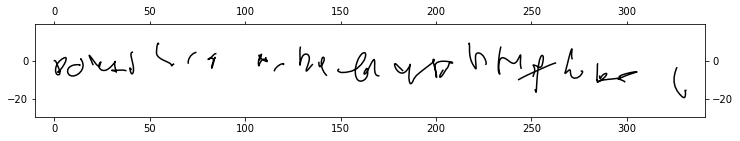

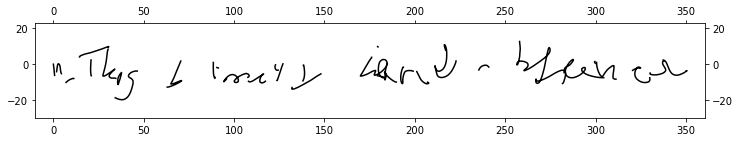

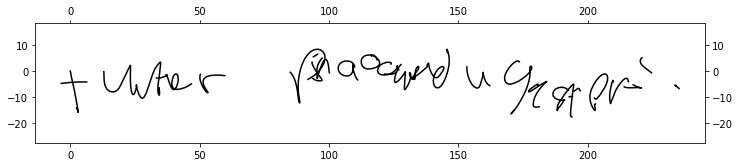

iteration: 1550 of 78000, avg_loss: -1994.29, timeSinceStart: 1351.69, Epoch: 19
iteration: 1600 of 78000, avg_loss: -2023.28, timeSinceStart: 1394.34, Epoch: 20
iteration: 1650 of 78000, avg_loss: -2022.01, timeSinceStart: 1437.03, Epoch: 21
iteration: 1700 of 78000, avg_loss: -2014.19, timeSinceStart: 1479.93, Epoch: 21
iteration: 1750 of 78000, avg_loss: -2035.31, timeSinceStart: 1522.60, Epoch: 22


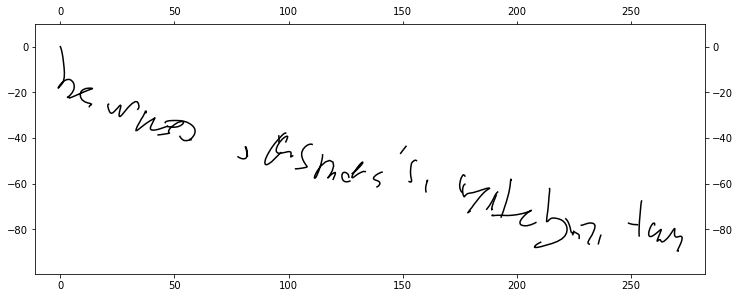

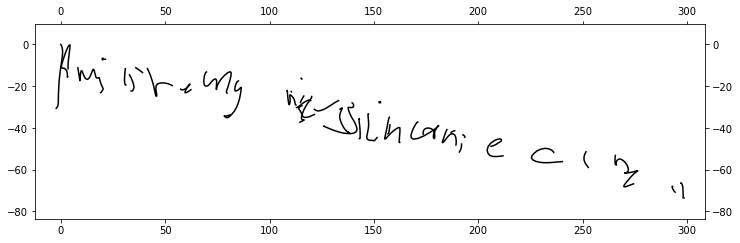

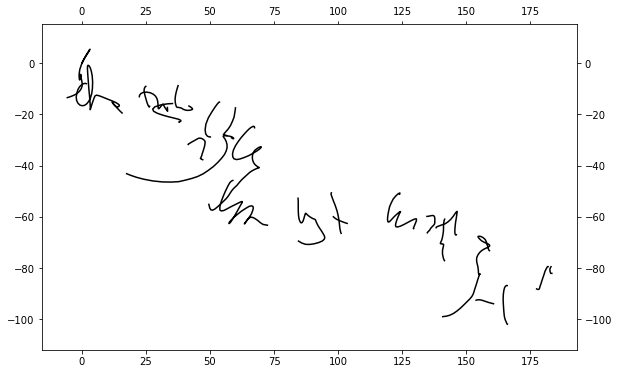

iteration: 1800 of 78000, avg_loss: -2019.96, timeSinceStart: 1568.27, Epoch: 23
iteration: 1850 of 78000, avg_loss: -2019.04, timeSinceStart: 1610.81, Epoch: 23
iteration: 1900 of 78000, avg_loss: -2039.90, timeSinceStart: 1653.30, Epoch: 24
iteration: 1950 of 78000, avg_loss: -2051.34, timeSinceStart: 1696.02, Epoch: 25
iteration: 2000 of 78000, avg_loss: -2066.06, timeSinceStart: 1738.51, Epoch: 25


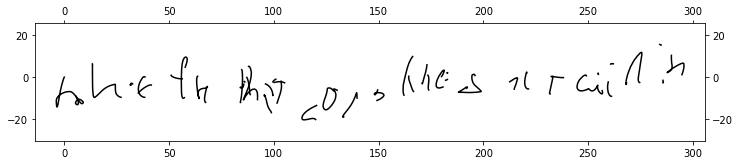

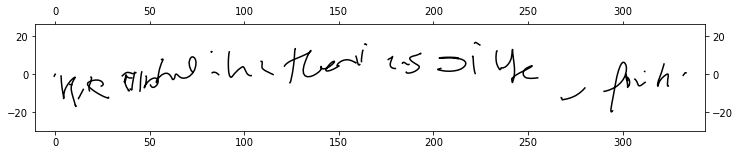

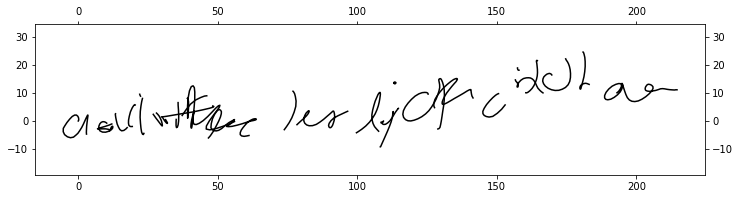

iteration: 2050 of 78000, avg_loss: -2077.32, timeSinceStart: 1784.14, Epoch: 26
iteration: 2100 of 78000, avg_loss: -2075.53, timeSinceStart: 1826.53, Epoch: 26
iteration: 2150 of 78000, avg_loss: -2094.23, timeSinceStart: 1869.28, Epoch: 27
iteration: 2200 of 78000, avg_loss: -2088.59, timeSinceStart: 1911.90, Epoch: 28
iteration: 2250 of 78000, avg_loss: -2104.36, timeSinceStart: 1954.34, Epoch: 28


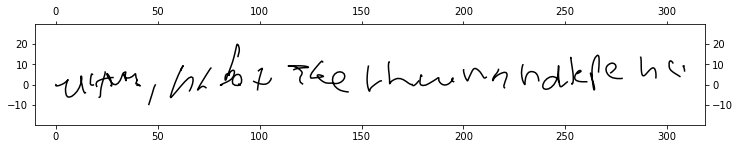

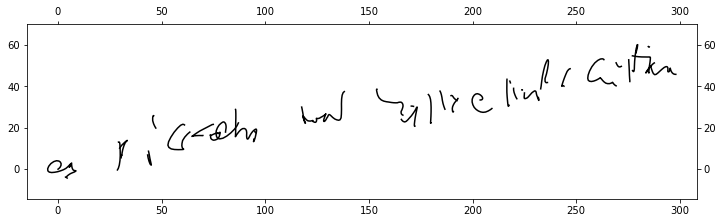

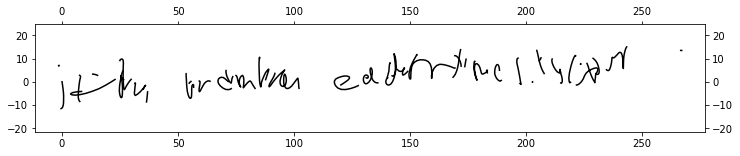

iteration: 2300 of 78000, avg_loss: -2105.31, timeSinceStart: 1999.94, Epoch: 29
iteration: 2350 of 78000, avg_loss: -2109.46, timeSinceStart: 2042.37, Epoch: 30
iteration: 2400 of 78000, avg_loss: -2114.81, timeSinceStart: 2085.10, Epoch: 30
iteration: 2450 of 78000, avg_loss: -2105.07, timeSinceStart: 2127.81, Epoch: 31
iteration: 2500 of 78000, avg_loss: -2121.24, timeSinceStart: 2170.42, Epoch: 32


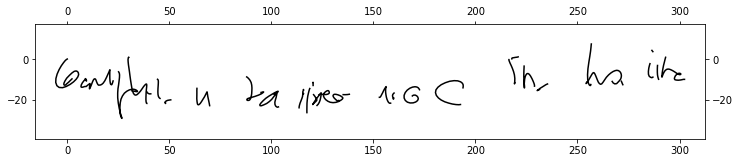

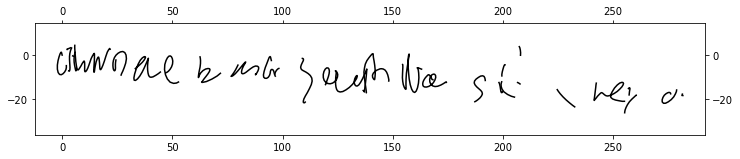

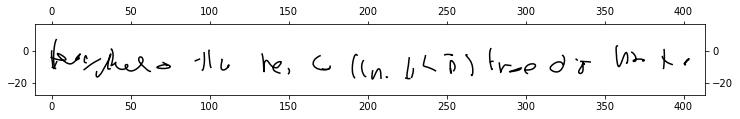

iteration: 2550 of 78000, avg_loss: -2131.72, timeSinceStart: 2216.16, Epoch: 32
iteration: 2600 of 78000, avg_loss: -2118.56, timeSinceStart: 2258.60, Epoch: 33
iteration: 2650 of 78000, avg_loss: -2128.47, timeSinceStart: 2301.28, Epoch: 33
iteration: 2700 of 78000, avg_loss: -2137.03, timeSinceStart: 2343.88, Epoch: 34
iteration: 2750 of 78000, avg_loss: -2133.09, timeSinceStart: 2386.58, Epoch: 35


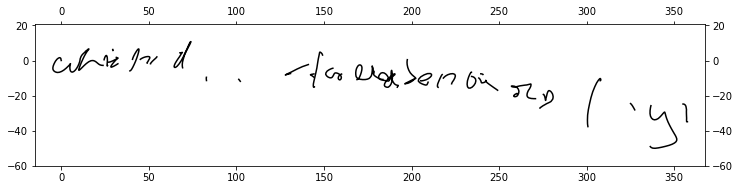

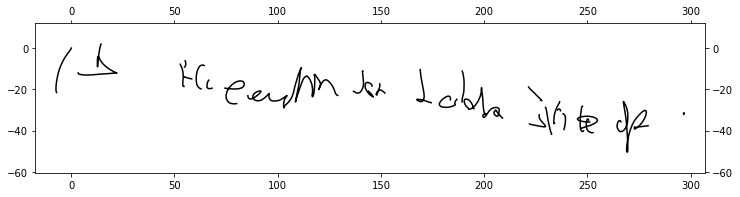

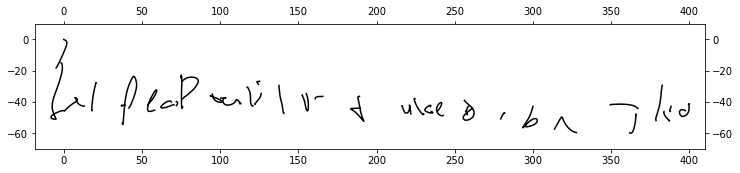

iteration: 2800 of 78000, avg_loss: -2149.94, timeSinceStart: 2432.26, Epoch: 35
iteration: 2850 of 78000, avg_loss: -2162.04, timeSinceStart: 2474.99, Epoch: 36
iteration: 2900 of 78000, avg_loss: -2153.07, timeSinceStart: 2517.53, Epoch: 37
iteration: 2950 of 78000, avg_loss: -2169.11, timeSinceStart: 2560.25, Epoch: 37
iteration: 3000 of 78000, avg_loss: -2174.17, timeSinceStart: 2602.82, Epoch: 38


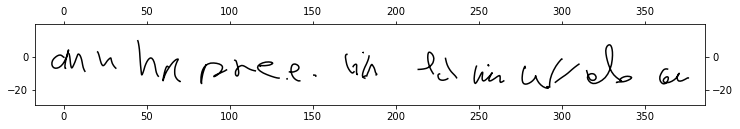

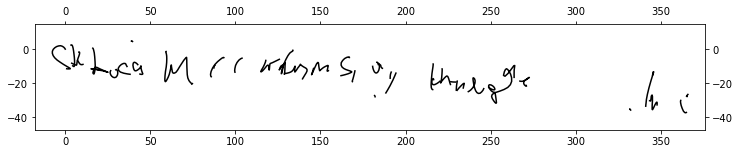

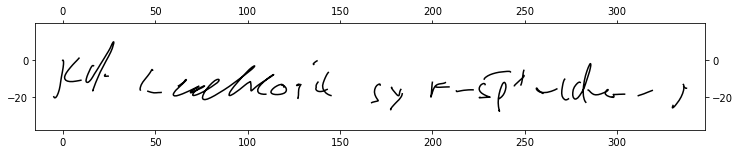

iteration: 3050 of 78000, avg_loss: -2169.06, timeSinceStart: 2648.52, Epoch: 39
iteration: 3100 of 78000, avg_loss: -2193.18, timeSinceStart: 2691.11, Epoch: 39
iteration: 3150 of 78000, avg_loss: -2185.49, timeSinceStart: 2733.56, Epoch: 40
iteration: 3200 of 78000, avg_loss: -2190.70, timeSinceStart: 2776.24, Epoch: 41
iteration: 3250 of 78000, avg_loss: -2189.44, timeSinceStart: 2818.83, Epoch: 41


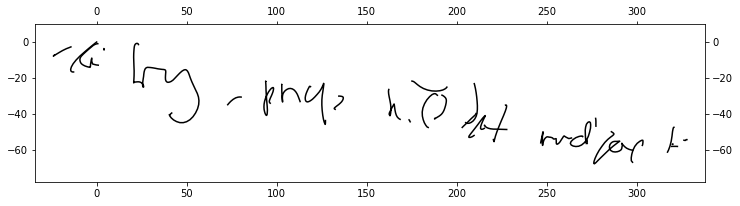

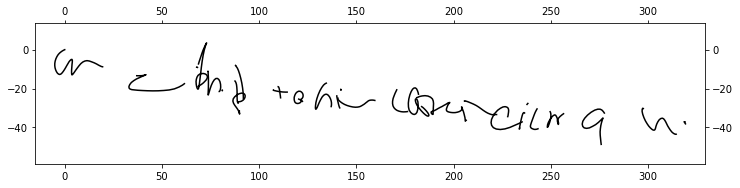

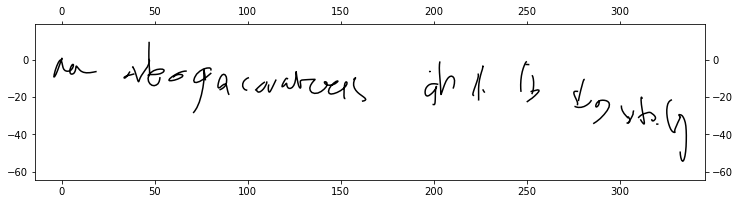

iteration: 3300 of 78000, avg_loss: -2197.99, timeSinceStart: 2864.51, Epoch: 42
iteration: 3350 of 78000, avg_loss: -2196.88, timeSinceStart: 2906.82, Epoch: 42
iteration: 3400 of 78000, avg_loss: -2211.21, timeSinceStart: 2949.35, Epoch: 43
iteration: 3450 of 78000, avg_loss: -2209.76, timeSinceStart: 2992.04, Epoch: 44
iteration: 3500 of 78000, avg_loss: -2207.46, timeSinceStart: 3034.67, Epoch: 44


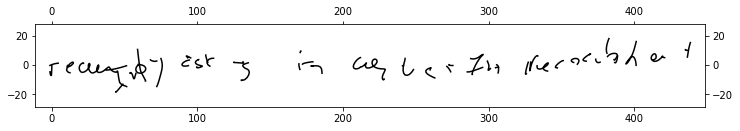

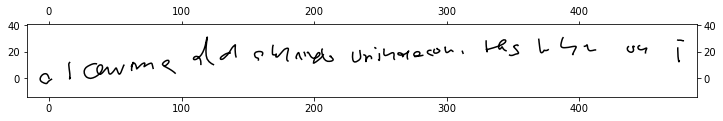

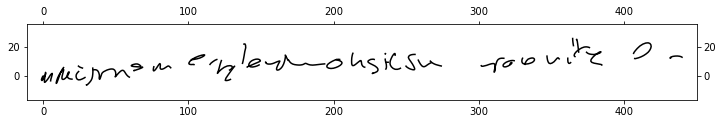

iteration: 3550 of 78000, avg_loss: -2219.71, timeSinceStart: 3080.44, Epoch: 45
iteration: 3600 of 78000, avg_loss: -2191.18, timeSinceStart: 3122.98, Epoch: 46
iteration: 3650 of 78000, avg_loss: -2226.66, timeSinceStart: 3165.61, Epoch: 46
iteration: 3700 of 78000, avg_loss: -2227.35, timeSinceStart: 3208.30, Epoch: 47
iteration: 3750 of 78000, avg_loss: -2211.03, timeSinceStart: 3250.97, Epoch: 48


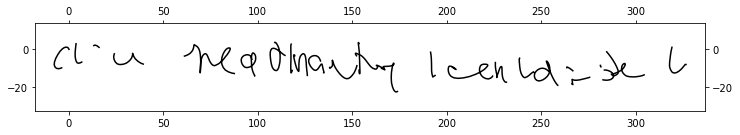

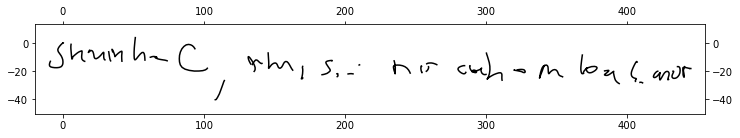

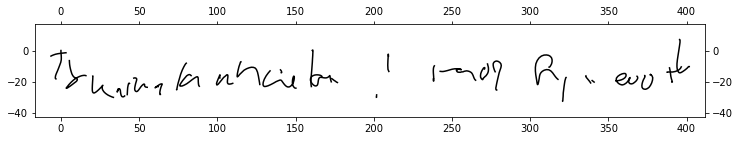

iteration: 3800 of 78000, avg_loss: -2223.65, timeSinceStart: 3296.45, Epoch: 48
iteration: 3850 of 78000, avg_loss: -2230.35, timeSinceStart: 3339.08, Epoch: 49
iteration: 3900 of 78000, avg_loss: -2236.61, timeSinceStart: 3381.66, Epoch: 50
iteration: 3950 of 78000, avg_loss: -2245.55, timeSinceStart: 3424.40, Epoch: 50
iteration: 4000 of 78000, avg_loss: -2235.51, timeSinceStart: 3466.95, Epoch: 51


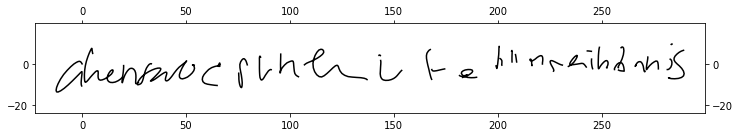

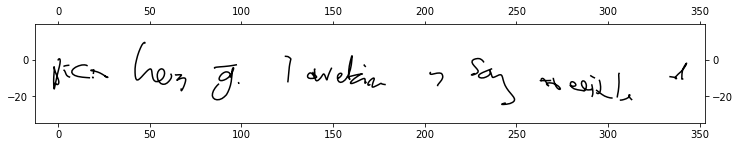

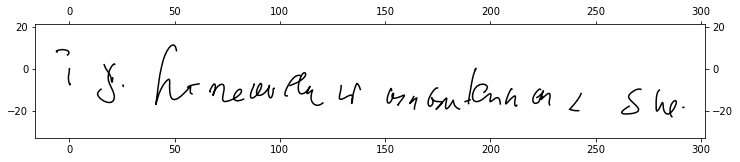

iteration: 4050 of 78000, avg_loss: -2243.74, timeSinceStart: 3512.84, Epoch: 51
iteration: 4100 of 78000, avg_loss: -2245.89, timeSinceStart: 3555.51, Epoch: 52
iteration: 4150 of 78000, avg_loss: -2243.75, timeSinceStart: 3598.02, Epoch: 53
iteration: 4200 of 78000, avg_loss: -2250.76, timeSinceStart: 3640.53, Epoch: 53
iteration: 4250 of 78000, avg_loss: -2242.84, timeSinceStart: 3683.28, Epoch: 54


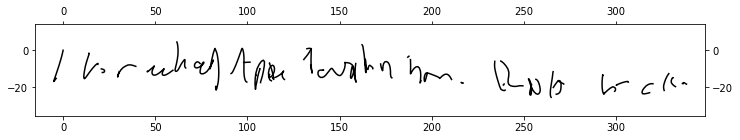

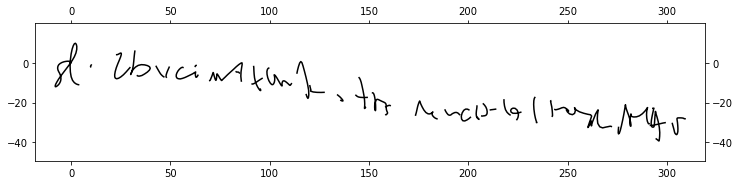

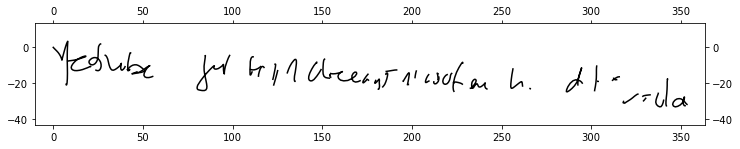

iteration: 4300 of 78000, avg_loss: -2246.04, timeSinceStart: 3728.90, Epoch: 55
iteration: 4350 of 78000, avg_loss: -2250.09, timeSinceStart: 3771.53, Epoch: 55
iteration: 4400 of 78000, avg_loss: -2234.81, timeSinceStart: 3814.17, Epoch: 56
iteration: 4450 of 78000, avg_loss: -2275.07, timeSinceStart: 3856.80, Epoch: 57
iteration: 4500 of 78000, avg_loss: -2264.49, timeSinceStart: 3899.56, Epoch: 57


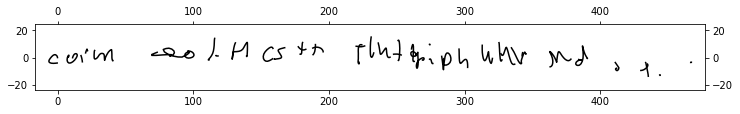

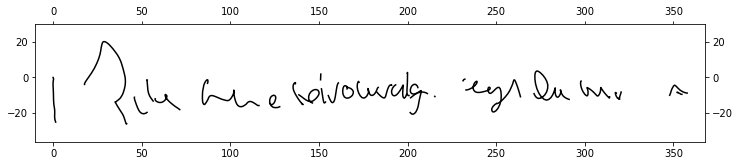

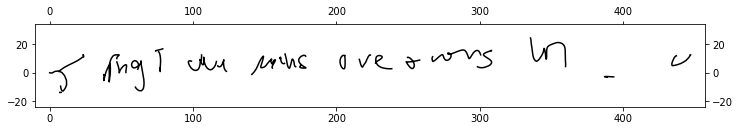

iteration: 4550 of 78000, avg_loss: -2268.99, timeSinceStart: 3945.24, Epoch: 58
iteration: 4600 of 78000, avg_loss: -2265.81, timeSinceStart: 3988.00, Epoch: 58
iteration: 4650 of 78000, avg_loss: -2273.54, timeSinceStart: 4030.72, Epoch: 59
iteration: 4700 of 78000, avg_loss: -2265.87, timeSinceStart: 4073.40, Epoch: 60
iteration: 4750 of 78000, avg_loss: -2279.52, timeSinceStart: 4116.06, Epoch: 60


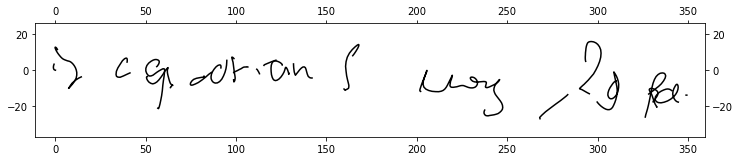

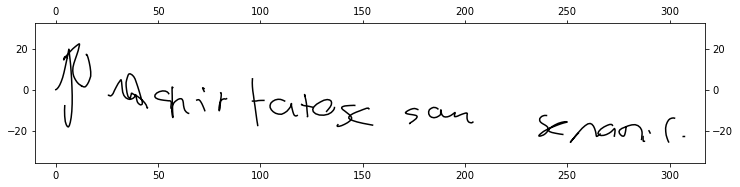

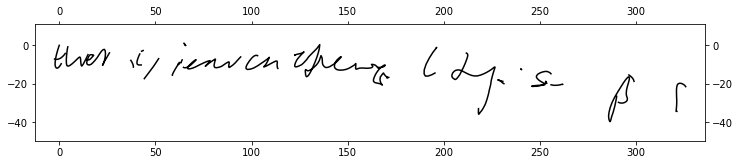

iteration: 4800 of 78000, avg_loss: -2267.31, timeSinceStart: 4161.80, Epoch: 61
iteration: 4850 of 78000, avg_loss: -2273.44, timeSinceStart: 4204.56, Epoch: 62
iteration: 4900 of 78000, avg_loss: -2273.70, timeSinceStart: 4247.23, Epoch: 62
iteration: 4950 of 78000, avg_loss: -2297.43, timeSinceStart: 4289.91, Epoch: 63
iteration: 5000 of 78000, avg_loss: -2282.39, timeSinceStart: 4332.50, Epoch: 64


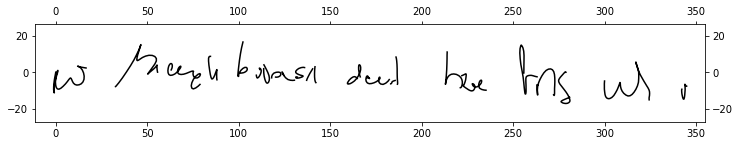

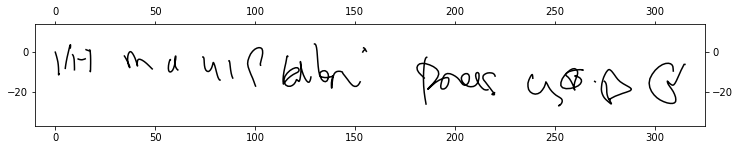

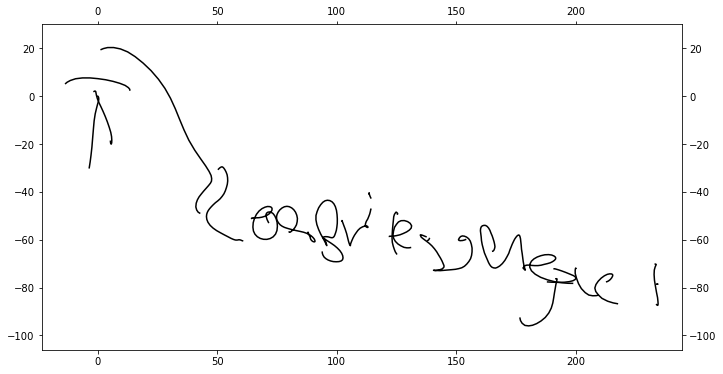

iteration: 5050 of 78000, avg_loss: -2286.56, timeSinceStart: 4378.09, Epoch: 64
iteration: 5100 of 78000, avg_loss: -2265.10, timeSinceStart: 4420.41, Epoch: 65
iteration: 5150 of 78000, avg_loss: -2289.43, timeSinceStart: 4462.61, Epoch: 66
iteration: 5200 of 78000, avg_loss: -2287.68, timeSinceStart: 4504.97, Epoch: 66
iteration: 5250 of 78000, avg_loss: -2291.04, timeSinceStart: 4547.32, Epoch: 67


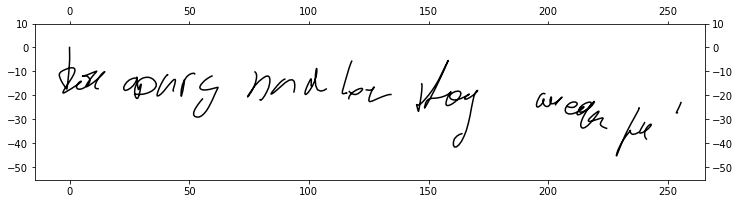

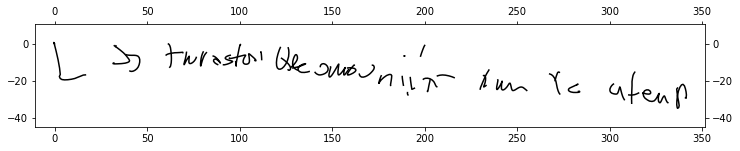

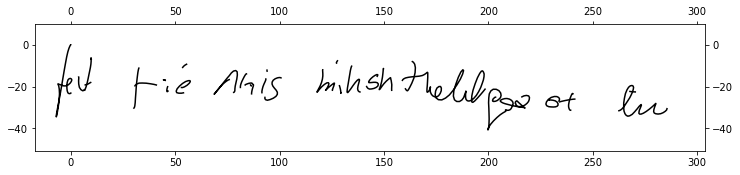

iteration: 5300 of 78000, avg_loss: -2289.39, timeSinceStart: 4592.44, Epoch: 67
iteration: 5350 of 78000, avg_loss: -2304.04, timeSinceStart: 4634.69, Epoch: 68
iteration: 5400 of 78000, avg_loss: -2300.92, timeSinceStart: 4676.82, Epoch: 69
iteration: 5450 of 78000, avg_loss: -2299.37, timeSinceStart: 4719.05, Epoch: 69
iteration: 5500 of 78000, avg_loss: -2314.98, timeSinceStart: 4761.19, Epoch: 70


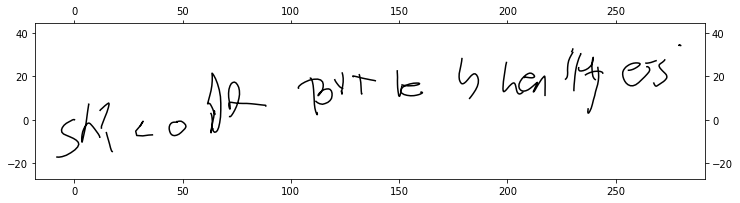

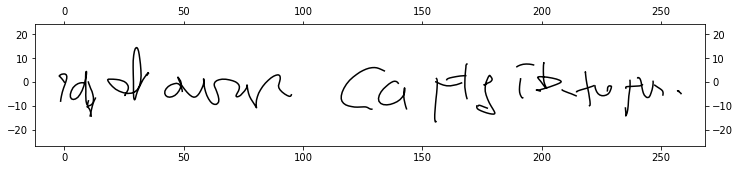

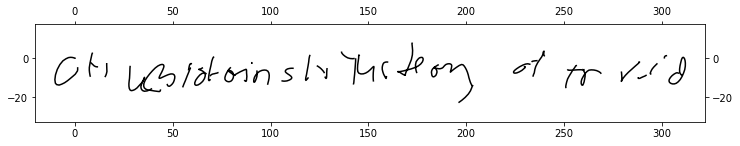

iteration: 5550 of 78000, avg_loss: -2292.27, timeSinceStart: 4806.30, Epoch: 71
iteration: 5600 of 78000, avg_loss: -2323.00, timeSinceStart: 4848.45, Epoch: 71
iteration: 5650 of 78000, avg_loss: -2314.68, timeSinceStart: 4890.68, Epoch: 72
iteration: 5700 of 78000, avg_loss: -2299.93, timeSinceStart: 4932.89, Epoch: 73
iteration: 5750 of 78000, avg_loss: -2309.90, timeSinceStart: 4975.14, Epoch: 73


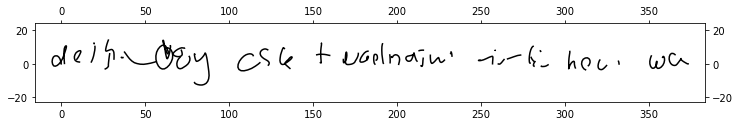

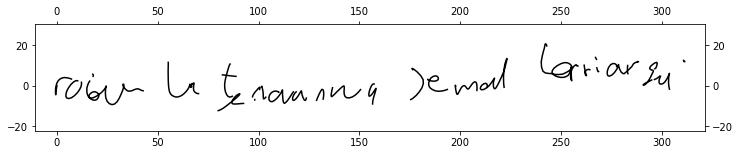

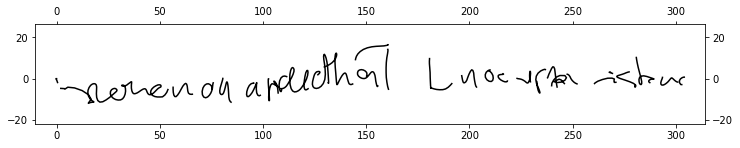

iteration: 5800 of 78000, avg_loss: -2319.79, timeSinceStart: 5020.32, Epoch: 74
iteration: 5850 of 78000, avg_loss: -2303.54, timeSinceStart: 5062.46, Epoch: 75
iteration: 5900 of 78000, avg_loss: -2324.32, timeSinceStart: 5104.61, Epoch: 75
iteration: 5950 of 78000, avg_loss: -2313.47, timeSinceStart: 5146.83, Epoch: 76
iteration: 6000 of 78000, avg_loss: -2310.14, timeSinceStart: 5188.98, Epoch: 76


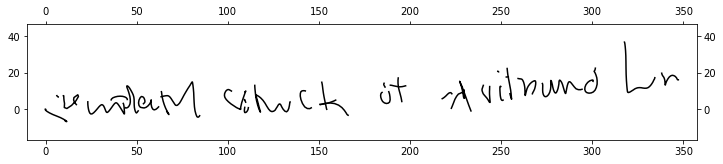

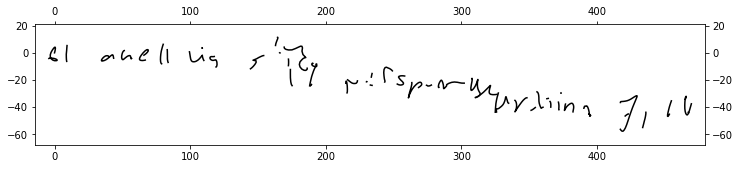

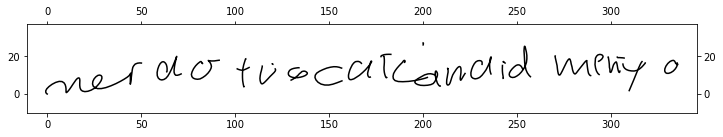

iteration: 6050 of 78000, avg_loss: -2336.47, timeSinceStart: 5233.77, Epoch: 77
iteration: 6100 of 78000, avg_loss: -2320.25, timeSinceStart: 5275.78, Epoch: 78
iteration: 6150 of 78000, avg_loss: -2331.27, timeSinceStart: 5317.82, Epoch: 78
iteration: 6200 of 78000, avg_loss: -2322.73, timeSinceStart: 5359.76, Epoch: 79
iteration: 6250 of 78000, avg_loss: -2320.94, timeSinceStart: 5401.77, Epoch: 80


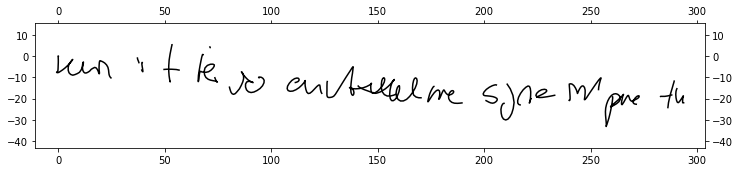

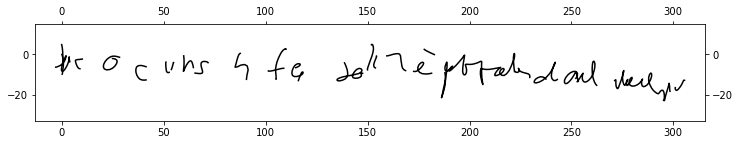

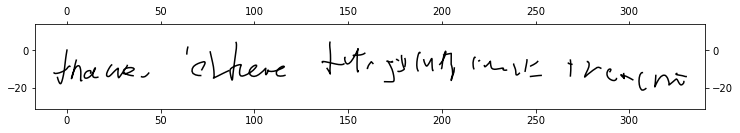

iteration: 6300 of 78000, avg_loss: -2329.18, timeSinceStart: 5446.85, Epoch: 80
iteration: 6350 of 78000, avg_loss: -2328.03, timeSinceStart: 5488.90, Epoch: 81
iteration: 6400 of 78000, avg_loss: -2330.99, timeSinceStart: 5531.02, Epoch: 82
iteration: 6450 of 78000, avg_loss: -2343.83, timeSinceStart: 5573.26, Epoch: 82
iteration: 6500 of 78000, avg_loss: -2330.08, timeSinceStart: 5615.47, Epoch: 83


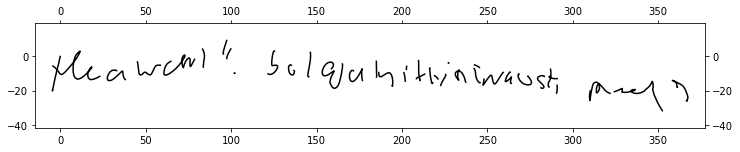

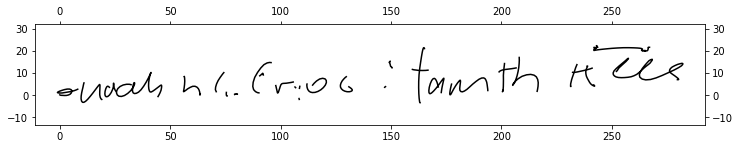

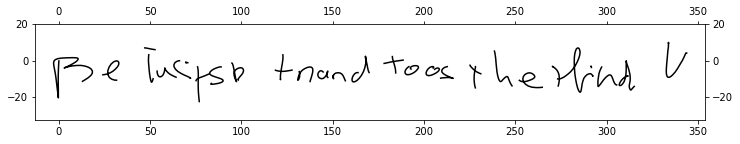

iteration: 6550 of 78000, avg_loss: -2333.09, timeSinceStart: 5660.55, Epoch: 83
iteration: 6600 of 78000, avg_loss: -2337.85, timeSinceStart: 5702.86, Epoch: 84
iteration: 6650 of 78000, avg_loss: -2335.23, timeSinceStart: 5745.10, Epoch: 85
iteration: 6700 of 78000, avg_loss: -2341.49, timeSinceStart: 5787.26, Epoch: 85
iteration: 6750 of 78000, avg_loss: -2339.52, timeSinceStart: 5829.47, Epoch: 86


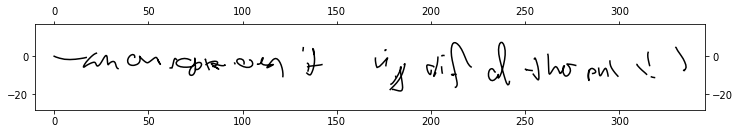

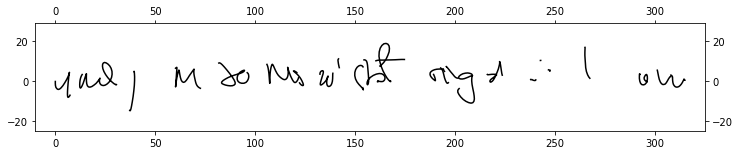

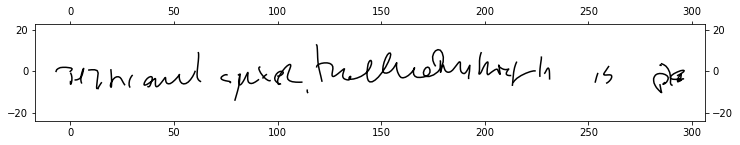

iteration: 6800 of 78000, avg_loss: -2341.99, timeSinceStart: 5874.52, Epoch: 87
iteration: 6850 of 78000, avg_loss: -2349.39, timeSinceStart: 5916.72, Epoch: 87
iteration: 6900 of 78000, avg_loss: -2349.68, timeSinceStart: 5958.92, Epoch: 88
iteration: 6950 of 78000, avg_loss: -2349.02, timeSinceStart: 6001.16, Epoch: 89
iteration: 7000 of 78000, avg_loss: -2336.46, timeSinceStart: 6043.49, Epoch: 89


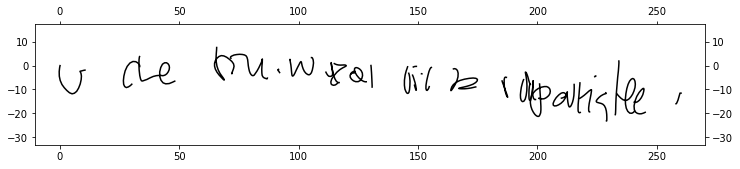

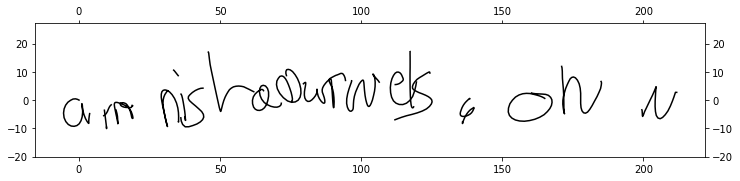

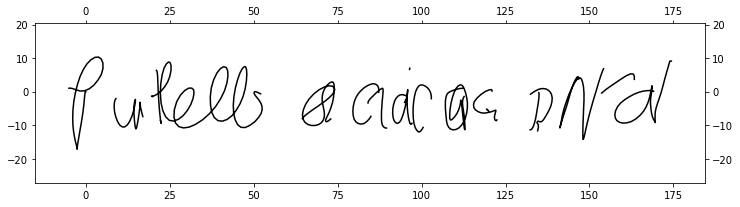

iteration: 7050 of 78000, avg_loss: -2347.66, timeSinceStart: 6088.53, Epoch: 90
iteration: 7100 of 78000, avg_loss: -2340.20, timeSinceStart: 6130.68, Epoch: 91
iteration: 7150 of 78000, avg_loss: -2357.05, timeSinceStart: 6172.97, Epoch: 91
iteration: 7200 of 78000, avg_loss: -2345.81, timeSinceStart: 6215.22, Epoch: 92
iteration: 7250 of 78000, avg_loss: -2350.78, timeSinceStart: 6257.38, Epoch: 92


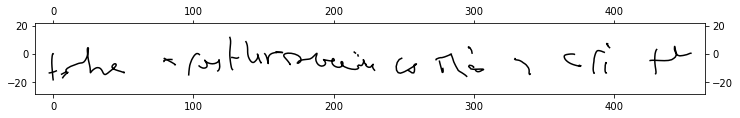

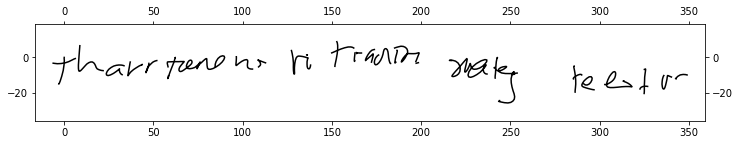

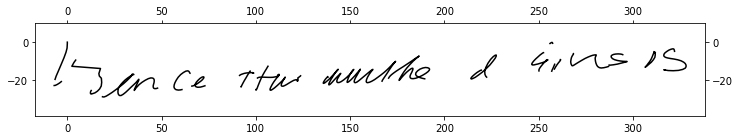

iteration: 7300 of 78000, avg_loss: -2366.55, timeSinceStart: 6302.38, Epoch: 93
iteration: 7350 of 78000, avg_loss: -2331.86, timeSinceStart: 6344.52, Epoch: 94
iteration: 7400 of 78000, avg_loss: -2363.07, timeSinceStart: 6386.59, Epoch: 94
iteration: 7450 of 78000, avg_loss: -2347.74, timeSinceStart: 6428.60, Epoch: 95
iteration: 7500 of 78000, avg_loss: -2361.67, timeSinceStart: 6470.65, Epoch: 96


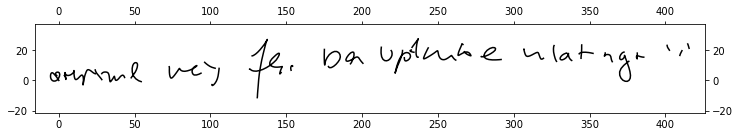

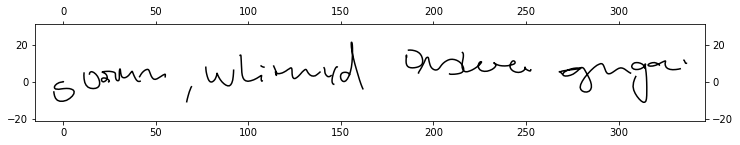

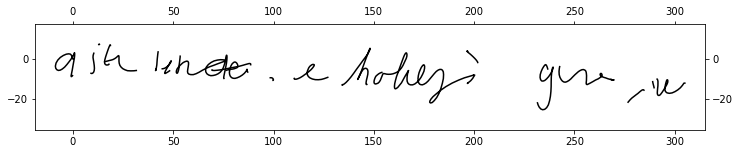

iteration: 7550 of 78000, avg_loss: -2359.46, timeSinceStart: 6515.66, Epoch: 96
iteration: 7600 of 78000, avg_loss: -2363.66, timeSinceStart: 6557.85, Epoch: 97
iteration: 7650 of 78000, avg_loss: -2360.57, timeSinceStart: 6600.05, Epoch: 98
iteration: 7700 of 78000, avg_loss: -2359.30, timeSinceStart: 6642.25, Epoch: 98
iteration: 7750 of 78000, avg_loss: -2374.62, timeSinceStart: 6684.47, Epoch: 99


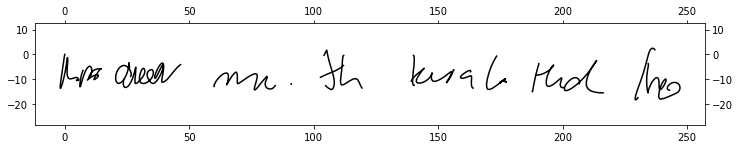

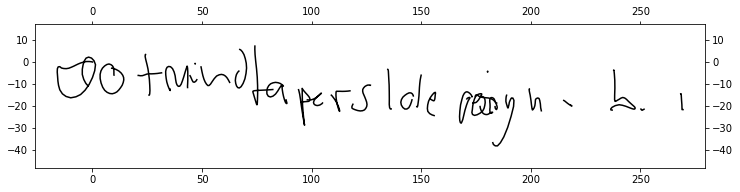

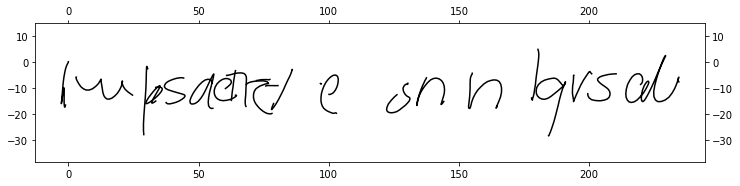

iteration: 7800 of 78000, avg_loss: -2365.69, timeSinceStart: 6729.57, Epoch: 100
iteration: 7850 of 78000, avg_loss: -2375.57, timeSinceStart: 6771.76, Epoch: 100
iteration: 7900 of 78000, avg_loss: -2367.77, timeSinceStart: 6813.98, Epoch: 101
iteration: 7950 of 78000, avg_loss: -2373.23, timeSinceStart: 6856.12, Epoch: 101
iteration: 8000 of 78000, avg_loss: -2365.50, timeSinceStart: 6898.37, Epoch: 102


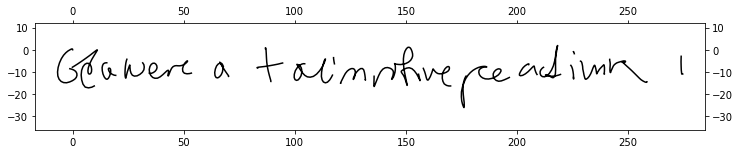

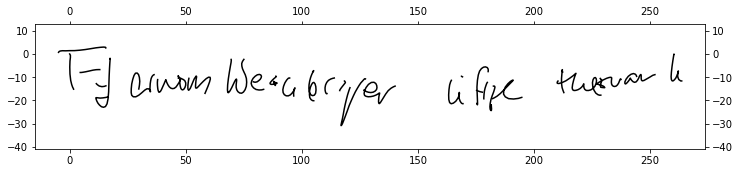

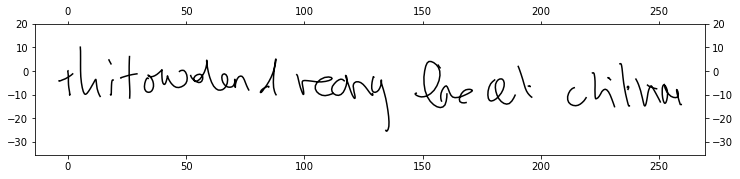

iteration: 8050 of 78000, avg_loss: -2372.13, timeSinceStart: 6943.42, Epoch: 103
iteration: 8100 of 78000, avg_loss: -2362.78, timeSinceStart: 6985.62, Epoch: 103
iteration: 8150 of 78000, avg_loss: -2378.76, timeSinceStart: 7027.80, Epoch: 104
iteration: 8200 of 78000, avg_loss: -2380.01, timeSinceStart: 7069.99, Epoch: 105
iteration: 8250 of 78000, avg_loss: -2369.75, timeSinceStart: 7112.28, Epoch: 105


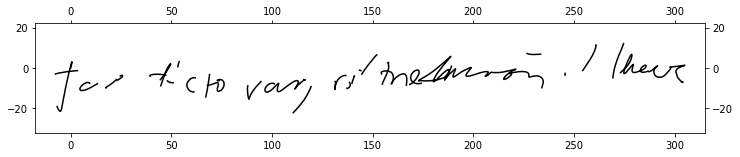

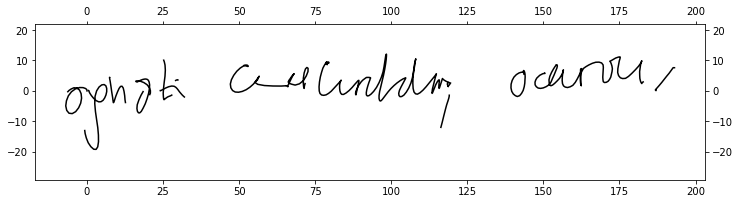

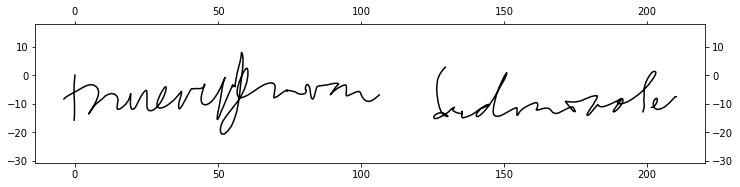

iteration: 8300 of 78000, avg_loss: -2379.31, timeSinceStart: 7157.45, Epoch: 106
iteration: 8350 of 78000, avg_loss: -2360.87, timeSinceStart: 7199.74, Epoch: 107
iteration: 8400 of 78000, avg_loss: -2379.17, timeSinceStart: 7241.94, Epoch: 107
iteration: 8450 of 78000, avg_loss: -2381.69, timeSinceStart: 7284.19, Epoch: 108
iteration: 8500 of 78000, avg_loss: -2376.77, timeSinceStart: 7326.50, Epoch: 108


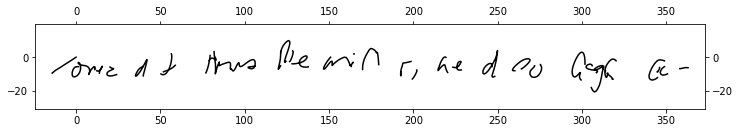

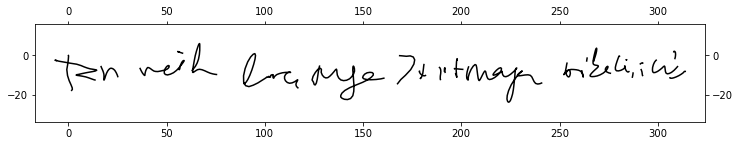

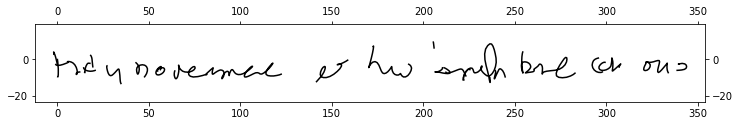

iteration: 8550 of 78000, avg_loss: -2383.78, timeSinceStart: 7371.67, Epoch: 109
iteration: 8600 of 78000, avg_loss: -2390.04, timeSinceStart: 7413.91, Epoch: 110
iteration: 8650 of 78000, avg_loss: -2369.68, timeSinceStart: 7456.06, Epoch: 110
iteration: 8700 of 78000, avg_loss: -2380.24, timeSinceStart: 7498.32, Epoch: 111
iteration: 8750 of 78000, avg_loss: -2393.34, timeSinceStart: 7540.61, Epoch: 112


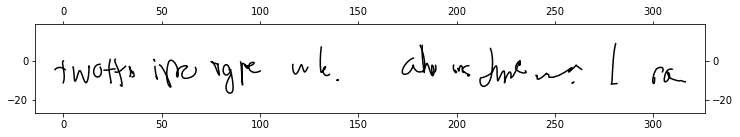

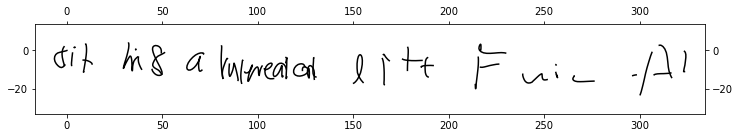

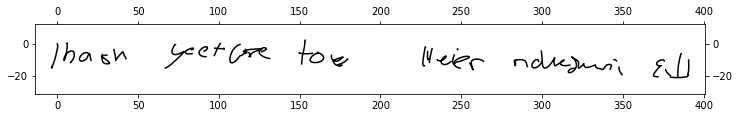

iteration: 8800 of 78000, avg_loss: -2381.75, timeSinceStart: 7585.77, Epoch: 112
iteration: 8850 of 78000, avg_loss: -2372.75, timeSinceStart: 7627.87, Epoch: 113
iteration: 8900 of 78000, avg_loss: -2389.47, timeSinceStart: 7670.02, Epoch: 114
iteration: 8950 of 78000, avg_loss: -2393.66, timeSinceStart: 7712.00, Epoch: 114
iteration: 9000 of 78000, avg_loss: -2384.00, timeSinceStart: 7753.98, Epoch: 115


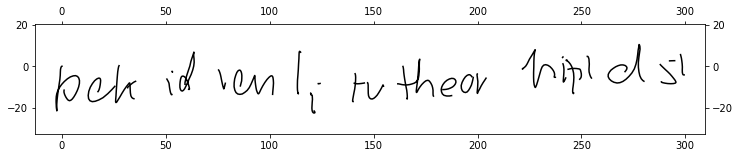

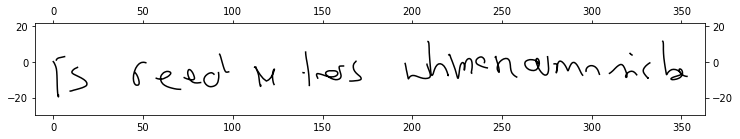

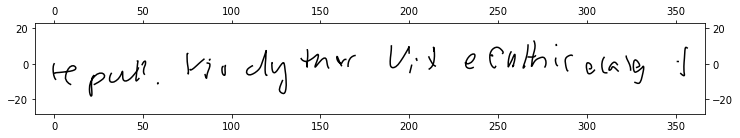

iteration: 9050 of 78000, avg_loss: -2388.94, timeSinceStart: 7798.93, Epoch: 116
iteration: 9100 of 78000, avg_loss: -2383.64, timeSinceStart: 7840.98, Epoch: 116
iteration: 9150 of 78000, avg_loss: -2401.71, timeSinceStart: 7883.20, Epoch: 117
iteration: 9200 of 78000, avg_loss: -2390.19, timeSinceStart: 7925.32, Epoch: 117
iteration: 9250 of 78000, avg_loss: -2400.36, timeSinceStart: 7967.52, Epoch: 118


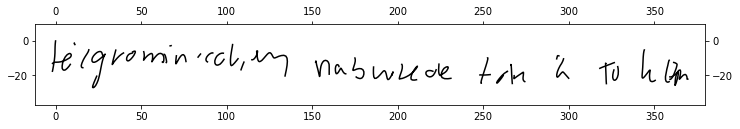

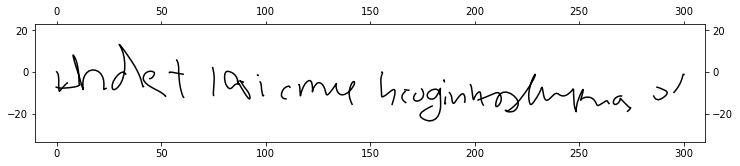

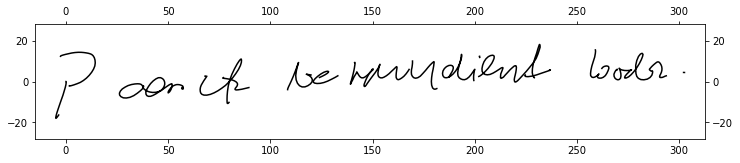

iteration: 9300 of 78000, avg_loss: -2371.32, timeSinceStart: 8012.64, Epoch: 119
iteration: 9350 of 78000, avg_loss: -2389.82, timeSinceStart: 8054.86, Epoch: 119
iteration: 9400 of 78000, avg_loss: -2398.41, timeSinceStart: 8097.02, Epoch: 120
iteration: 9450 of 78000, avg_loss: -2400.13, timeSinceStart: 8139.31, Epoch: 121
iteration: 9500 of 78000, avg_loss: -2390.24, timeSinceStart: 8181.61, Epoch: 121


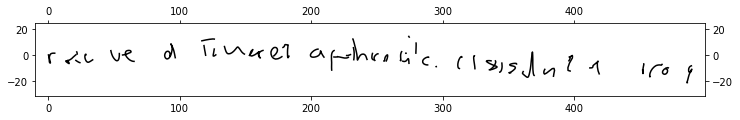

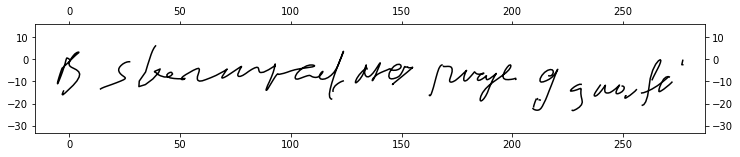

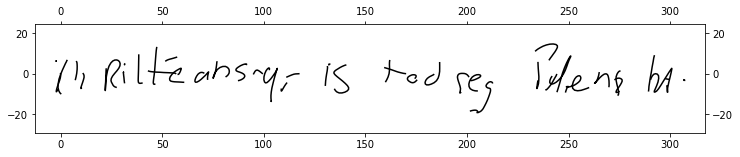

iteration: 9550 of 78000, avg_loss: -2409.24, timeSinceStart: 8226.77, Epoch: 122
iteration: 9600 of 78000, avg_loss: -2390.65, timeSinceStart: 8269.16, Epoch: 123
iteration: 9650 of 78000, avg_loss: -2388.41, timeSinceStart: 8311.37, Epoch: 123
iteration: 9700 of 78000, avg_loss: -2405.79, timeSinceStart: 8353.59, Epoch: 124
iteration: 9750 of 78000, avg_loss: -2392.01, timeSinceStart: 8395.82, Epoch: 125


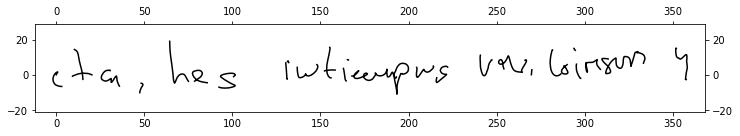

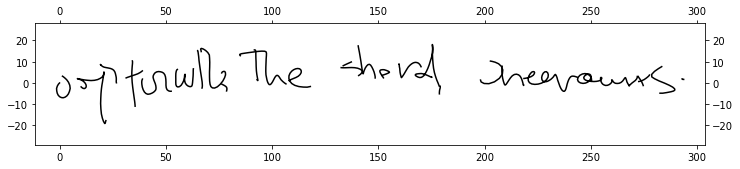

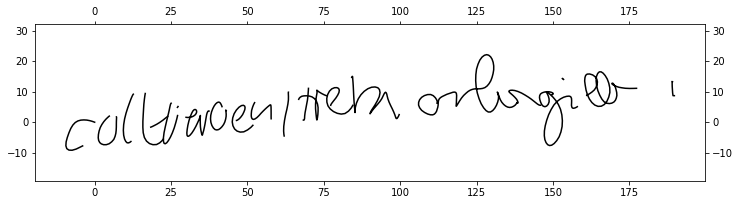

iteration: 9800 of 78000, avg_loss: -2394.46, timeSinceStart: 8440.86, Epoch: 125
iteration: 9850 of 78000, avg_loss: -2396.55, timeSinceStart: 8483.09, Epoch: 126
iteration: 9900 of 78000, avg_loss: -2399.16, timeSinceStart: 8525.29, Epoch: 126
iteration: 9950 of 78000, avg_loss: -2408.50, timeSinceStart: 8567.42, Epoch: 127
iteration: 10000 of 78000, avg_loss: -2400.30, timeSinceStart: 8609.59, Epoch: 128


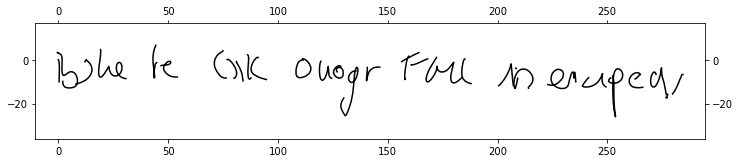

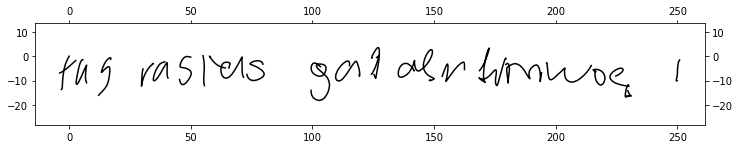

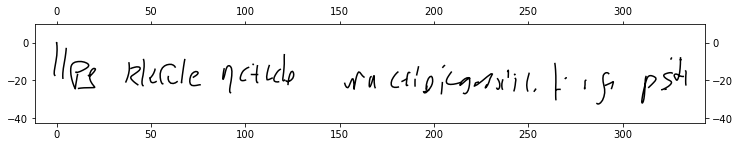

iteration: 10050 of 78000, avg_loss: -2401.51, timeSinceStart: 8654.70, Epoch: 128
iteration: 10100 of 78000, avg_loss: -2395.13, timeSinceStart: 8696.86, Epoch: 129
iteration: 10150 of 78000, avg_loss: -2401.87, timeSinceStart: 8739.02, Epoch: 130
iteration: 10200 of 78000, avg_loss: -2395.10, timeSinceStart: 8781.22, Epoch: 130
iteration: 10250 of 78000, avg_loss: -2405.94, timeSinceStart: 8823.48, Epoch: 131


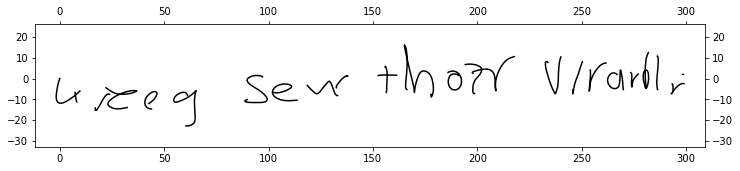

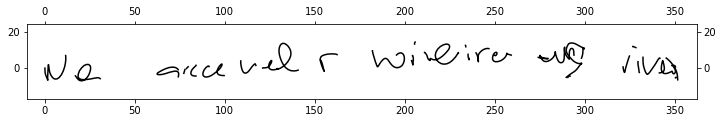

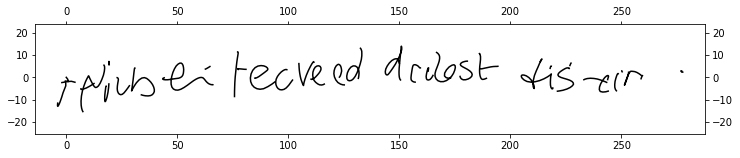

iteration: 10300 of 78000, avg_loss: -2402.76, timeSinceStart: 8868.72, Epoch: 132
iteration: 10350 of 78000, avg_loss: -2394.69, timeSinceStart: 8910.91, Epoch: 132
iteration: 10400 of 78000, avg_loss: -2414.04, timeSinceStart: 8953.06, Epoch: 133
iteration: 10450 of 78000, avg_loss: -2392.36, timeSinceStart: 8995.31, Epoch: 133
iteration: 10500 of 78000, avg_loss: -2404.30, timeSinceStart: 9037.51, Epoch: 134


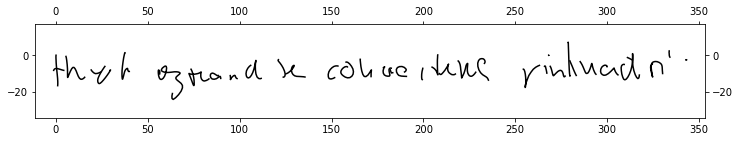

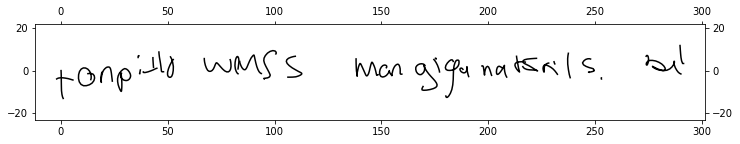

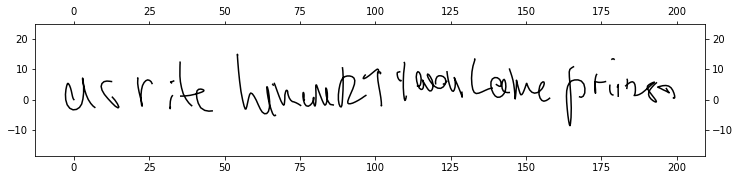

iteration: 10550 of 78000, avg_loss: -2403.73, timeSinceStart: 9082.75, Epoch: 135
iteration: 10600 of 78000, avg_loss: -2404.86, timeSinceStart: 9125.00, Epoch: 135
iteration: 10650 of 78000, avg_loss: -2400.34, timeSinceStart: 9167.26, Epoch: 136
iteration: 10700 of 78000, avg_loss: -2415.36, timeSinceStart: 9209.50, Epoch: 137
iteration: 10750 of 78000, avg_loss: -2413.79, timeSinceStart: 9251.66, Epoch: 137


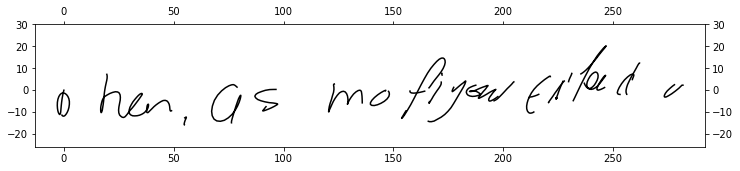

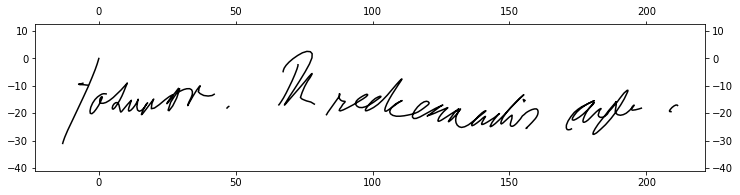

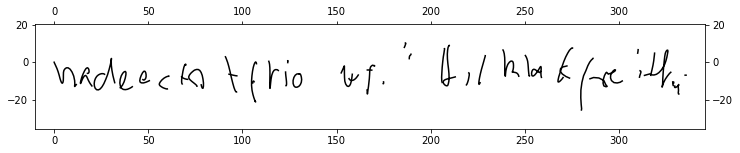

iteration: 10800 of 78000, avg_loss: -2395.59, timeSinceStart: 9296.67, Epoch: 138
iteration: 10850 of 78000, avg_loss: -2428.21, timeSinceStart: 9338.76, Epoch: 139
iteration: 10900 of 78000, avg_loss: -2414.18, timeSinceStart: 9380.92, Epoch: 139
iteration: 10950 of 78000, avg_loss: -2406.14, timeSinceStart: 9423.06, Epoch: 140
iteration: 11000 of 78000, avg_loss: -2422.53, timeSinceStart: 9465.14, Epoch: 141


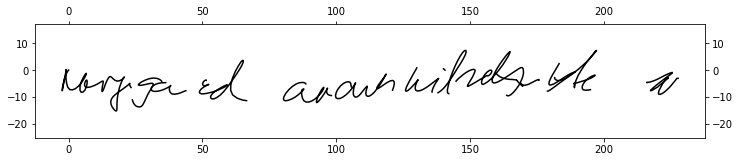

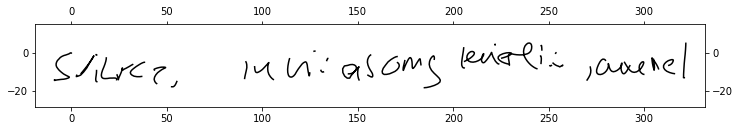

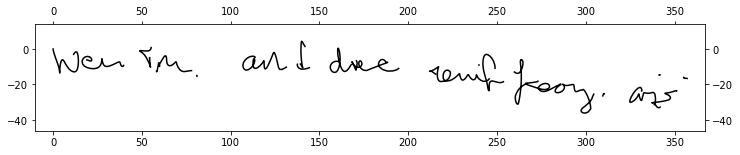

iteration: 11050 of 78000, avg_loss: -2415.28, timeSinceStart: 9510.51, Epoch: 141
iteration: 11100 of 78000, avg_loss: -2415.09, timeSinceStart: 9553.08, Epoch: 142
iteration: 11150 of 78000, avg_loss: -2413.94, timeSinceStart: 9595.58, Epoch: 142
iteration: 11200 of 78000, avg_loss: -2427.99, timeSinceStart: 9638.36, Epoch: 143
iteration: 11250 of 78000, avg_loss: -2398.74, timeSinceStart: 9681.03, Epoch: 144


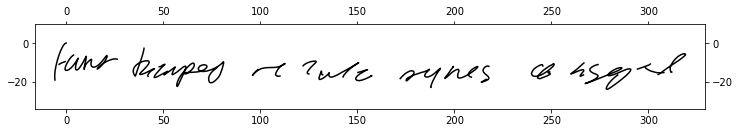

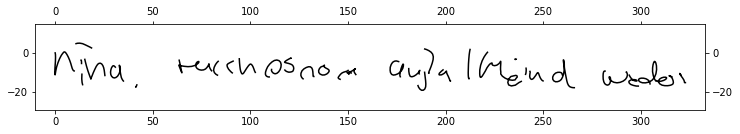

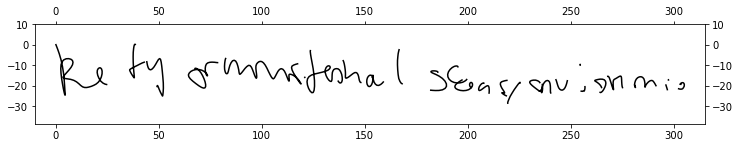

iteration: 11300 of 78000, avg_loss: -2413.12, timeSinceStart: 9726.62, Epoch: 144
iteration: 11350 of 78000, avg_loss: -2416.05, timeSinceStart: 9769.23, Epoch: 145
iteration: 11400 of 78000, avg_loss: -2419.25, timeSinceStart: 9811.89, Epoch: 146
iteration: 11450 of 78000, avg_loss: -2420.06, timeSinceStart: 9854.36, Epoch: 146
iteration: 11500 of 78000, avg_loss: -2421.90, timeSinceStart: 9897.08, Epoch: 147


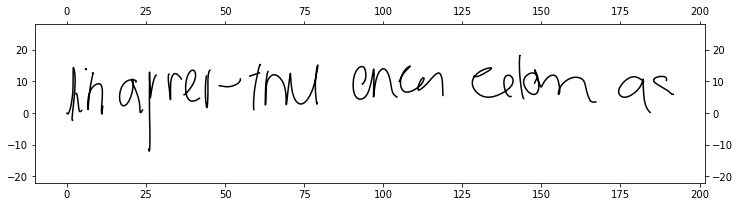

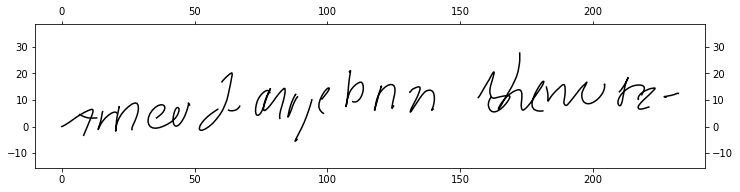

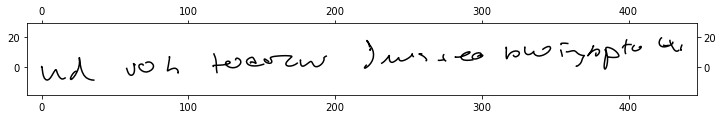

iteration: 11550 of 78000, avg_loss: -2428.24, timeSinceStart: 9942.79, Epoch: 148
iteration: 11600 of 78000, avg_loss: -2417.14, timeSinceStart: 9985.41, Epoch: 148
iteration: 11650 of 78000, avg_loss: -2432.97, timeSinceStart: 10028.17, Epoch: 149
iteration: 11700 of 78000, avg_loss: -2414.57, timeSinceStart: 10070.80, Epoch: 150


ValueError: Expected parameter loc (Tensor of shape (128, 1199, 20, 2)) of distribution MultivariateNormal(loc: torch.Size([128, 1199, 20, 2]), covariance_matrix: torch.Size([128, 1199, 20, 2, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        ...,


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]]], device='cuda:2', grad_fn=<ExpandBackward>)

In [17]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
